### Прогнозирование увольнения сотрудников <br>
Описание проекта<br> 
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.<br>
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.<br> 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 
Есть две задачи:<br> 
Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. <br>
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.<br>
Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.<br>

### План исследования <br>
На основе предоставленных данных проведем анализ и подберем лучшие модели для предсказания: 1. уровня удовлетворённости сотрудника; 2. увольнения сотрудника.

### Описание данных<br>
Задача 1: предсказание уровня удовлетворённости сотрудника<br>
Данные с признаками:<br>
id — уникальный идентификатор сотрудника;<br>
dept — отдел, в котором работает сотрудник;<br>
level — уровень занимаемой должности;<br>
workload — уровень загруженности сотрудника;<br>
employment_years — длительность работы в компании (в годах);<br>
last_year_promo — показывает, было ли повышение за последний год;<br>
last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;<br>
supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;<br>
salary — ежемесячная зарплата сотрудника;<br>
job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.<br>

Задача 2: предсказание увольнения сотрудника из компании<br>
Для этой задачи используем те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.<br>

In [98]:
# загрузка необходимых библиотек
!pip install scikit-learn==1.1.3 -q
#!pip install matplotlib==3.5.2 -q
#!pip install shap==0.44.0 -q

### Задача 1: Предсказание уровня удовлетворённости сотрудника. Шаг 1. Загрузка данных

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import spearmanr, f_oneway, kruskal

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_score
)
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    Ridge
)
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    MinMaxScaler,
    OrdinalEncoder,
    RobustScaler,
    LabelEncoder
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    f1_score,
    classification_report,
    make_scorer,
    roc_auc_score
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import (
    RandomForestRegressor, 
    HistGradientBoostingRegressor, 
    RandomForestClassifier, 
    HistGradientBoostingClassifier
) 

In [100]:
# Тренировочная выборка:
train_job_satis = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
# Входные признаки тестовой выборки:
test_features = pd.read_csv('/datasets/test_features.csv') 
# Целевой признак тестовой выборки:
test_target_job_satis = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv') 

### Шаг 2. Предобработка данных

Изучим данные

In [101]:
train_job_satis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [102]:
train_job_satis.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [103]:
# дубликаты
train_job_satis.duplicated().sum()

0

In [104]:
# оценим неявные дубликаты, изучив уникальные значения строковых колонок
cols_to_check = ['id', 'dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

for col in cols_to_check:
    print(f"\n--- Уникальные значения в колонке '{col}': ---")
    print(train_job_satis[col].unique())
    print(f"Всего уникальных значений: {train_job_satis[col].nunique()}")


--- Уникальные значения в колонке 'id': ---
[155278 653870 184592 ... 533318 706868 338347]
Всего уникальных значений: 4000

--- Уникальные значения в колонке 'dept': ---
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Всего уникальных значений: 5

--- Уникальные значения в колонке 'level': ---
['junior' 'middle' 'sinior' nan]
Всего уникальных значений: 3

--- Уникальные значения в колонке 'workload': ---
['medium' 'high' 'low']
Всего уникальных значений: 3

--- Уникальные значения в колонке 'last_year_promo': ---
['no' 'yes']
Всего уникальных значений: 2

--- Уникальные значения в колонке 'last_year_violations': ---
['no' 'yes']
Всего уникальных значений: 2


In [105]:
# исправим опечатку в level
train_job_satis['level'] = train_job_satis['level'].replace('sinior', 'senior')

In [106]:
# строки с пропусками
train_job_satis[train_job_satis[['dept', 'level']].isna().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


train_job_satis имеет 10 колонок, 4000 строк, есть пропуски в "debt" (6 шт) и "level" (4 шт). Типы данных соответствуют значениям. Дубликатов нет. Уникальные значения строковых колонок в порядке.

In [107]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [108]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [109]:
# дубликаты
test_features.duplicated().sum()

0

In [110]:
# оценим неявные дубликаты, изучив уникальные значения строковых колонок
cols_to_check = ['id', 'dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

for col in cols_to_check:
    print(f"\n--- Уникальные значения в колонке '{col}': ---")
    print(test_features[col].unique())
    print(f"Всего уникальных значений: {test_features[col].nunique()}")


--- Уникальные значения в колонке 'id': ---
[485046 686555 467458 ... 305653 160233 771859]
Всего уникальных значений: 2000

--- Уникальные значения в колонке 'dept': ---
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Всего уникальных значений: 6

--- Уникальные значения в колонке 'level': ---
['junior' 'middle' 'sinior' nan]
Всего уникальных значений: 3

--- Уникальные значения в колонке 'workload': ---
['medium' 'low' 'high' ' ']
Всего уникальных значений: 4

--- Уникальные значения в колонке 'last_year_promo': ---
['no' 'yes']
Всего уникальных значений: 2

--- Уникальные значения в колонке 'last_year_violations': ---
['no' 'yes']
Всего уникальных значений: 2


In [113]:
# проверим
cols_to_check = ['id', 'dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

for col in cols_to_check:
    print(f"\n--- Уникальные значения в колонке '{col}': ---")
    print(test_features[col].unique())
    print(f"Всего уникальных значений: {test_features[col].nunique()}")


--- Уникальные значения в колонке 'id': ---
[485046 686555 467458 ... 305653 160233 771859]
Всего уникальных значений: 2000

--- Уникальные значения в колонке 'dept': ---
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Всего уникальных значений: 6

--- Уникальные значения в колонке 'level': ---
['junior' 'middle' 'sinior' nan]
Всего уникальных значений: 3

--- Уникальные значения в колонке 'workload': ---
['medium' 'low' 'high' ' ']
Всего уникальных значений: 4

--- Уникальные значения в колонке 'last_year_promo': ---
['no' 'yes']
Всего уникальных значений: 2

--- Уникальные значения в колонке 'last_year_violations': ---
['no' 'yes']
Всего уникальных значений: 2


   <font color='4682B4'>V1 test_features имеет 9 колонок, 2000 строк, есть пропуски в "debt" (2 шт) и "level" (1 шт). Типы данных соответствуют значениям. Дубликатов нет. Уникальные значения строковых колонок в порядке.</font>
</div>

In [114]:
test_target_job_satis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [115]:
test_target_job_satis.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [116]:
test_target_job_satis.duplicated().sum()

0

In [117]:
print(test_target_job_satis['job_satisfaction_rate'].unique())
test_target_job_satis['job_satisfaction_rate'].nunique()

[0.74 0.75 0.6  0.72 0.08 0.76 0.64 0.38 0.14 0.59 0.91 0.78 0.7  0.79
 0.34 0.81 0.23 0.4  0.58 0.77 0.68 0.24 0.42 0.69 0.47 0.35 0.71 0.83
 0.61 0.65 0.37 0.45 0.63 0.82 0.16 0.89 0.28 0.32 0.88 0.36 0.33 0.31
 0.27 0.73 0.53 0.26 0.57 0.2  1.   0.56 0.67 0.19 0.52 0.43 0.12 0.11
 0.21 0.13 0.49 0.22 0.86 0.46 0.41 0.48 0.29 0.87 0.66 0.8  0.55 0.5
 0.51 0.62 0.85 0.84 0.15 0.39 0.25 0.9  0.07 0.1  0.92 0.3  0.44 0.18
 0.93 0.54 0.96 0.09 0.99 0.17 0.95 0.06 0.94 0.03 0.98 0.97 0.04 0.05]


98

test_target_job_satis имеет 2 колонки, 2000 строк, пропусков нет. Типы данных соответствуют значениям. Дубликатов нет.

</font><font color='Blue'><b>Вывод по предобработке</b></font><br>
Изучили таблицы. <br>
train_job_satis имеет 10 колонок, 4000 строк, есть пропуски в "debt" (6 шт) и "level" (4 шт). Типы данных соответствуют значениям. Дубликатов нет. Уникальные значения строковых колонок в порядке.<br>
test_features имеет 9 колонок, 2000 строк, есть пропуски в "debt" (2 шт) и "level" (1 шт). Типы данных соответствуют значениям. Дубликатов нет. Уникальные значения строковых колонок в порядке.<br>
test_target_job_satis имеет 2 колонки, 2000 строк, пропусков нет. Типы данных соответствуют значениям. Дубликатов нет.<br>
Незначительные пропуски обработаем на стадии пайплайна.

### Шаг 3. Исследовательский анализ данных

In [118]:
# Тренировочная выборка
train_job_satis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [119]:
train_job_satis.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [120]:
# оценим количественные значения
train_job_satis.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


   <br />
    <font color='4682B4'>Удалил employment_years и supervisor_evaluation</font>
</div>

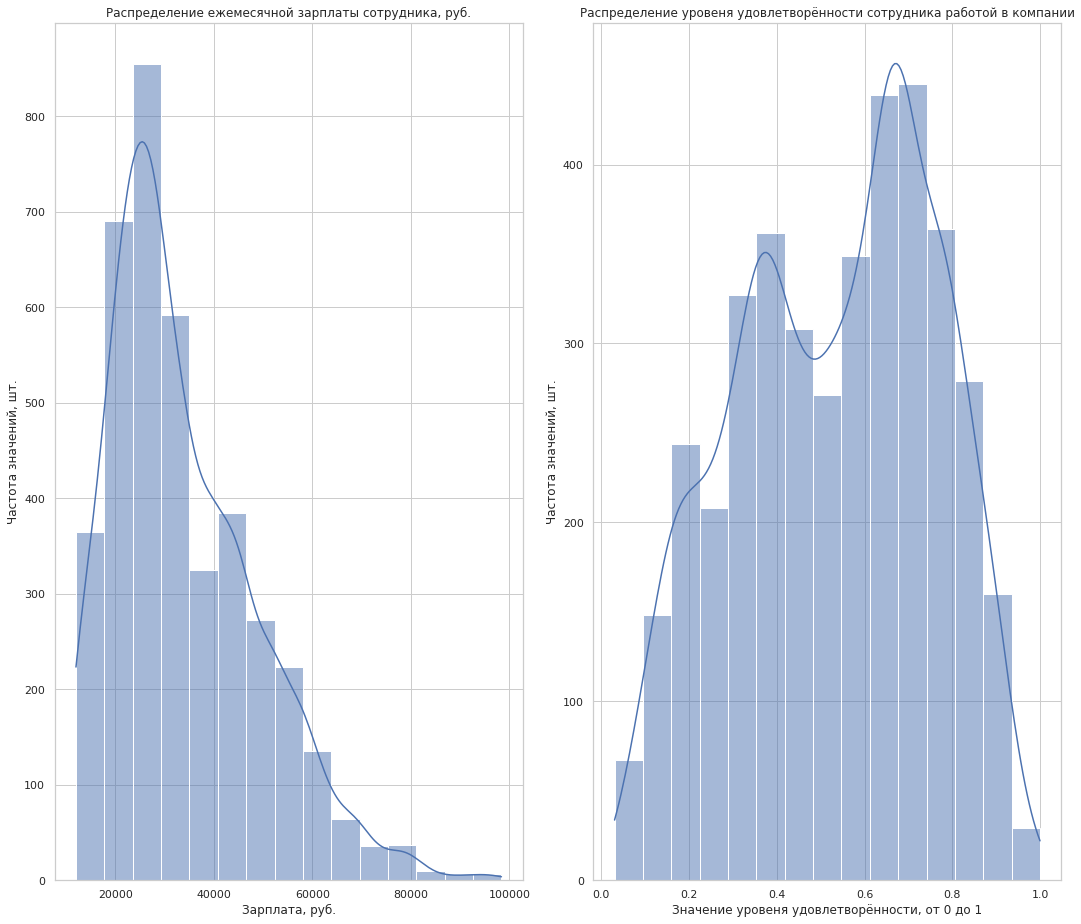

In [122]:
# Количественные признаки (непрерывные)
num_cols = ['salary', 'job_satisfaction_rate']

# Словарь с подписями для графиков
labels_dict = {
    'salary': ["Распределение ежемесячной зарплаты сотрудника, руб.", "Зарплата, руб.", "Частота значений, шт."],
    'job_satisfaction_rate': ["Распределение уровеня удовлетворённости сотрудника работой в компании", "Значение уровеня удовлетворённости, от 0 до 1", "Частота значений, шт."]
}

# Построение гистограмм с кастомными подписями
plt.figure(figsize=(15, 13))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 2, i)
    sns.histplot(train_job_satis[col], kde=True, bins=15)

    # Получаем подписи из словаря
    title, xlabel, ylabel = labels_dict.get(col, [col, col, "Частота"])
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

plt.tight_layout()
plt.show()

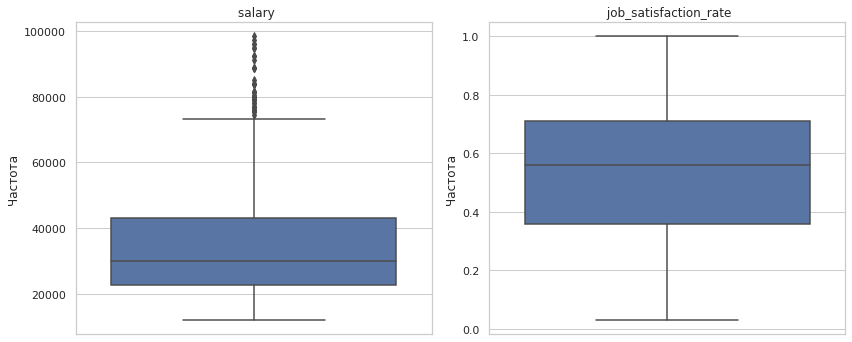

In [123]:
# ящики с усами с выбросами
plt.figure(figsize=(12, 14))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(y=train_job_satis[col])
    plt.title(f' {col}')
    plt.ylabel('Частота')
plt.tight_layout()
plt.show()

   <br />
    <font color='4682B4'>Ниже обновленный код для категоральных данных с добавлением employment_years и supervisor_evaluation</font>
</div>

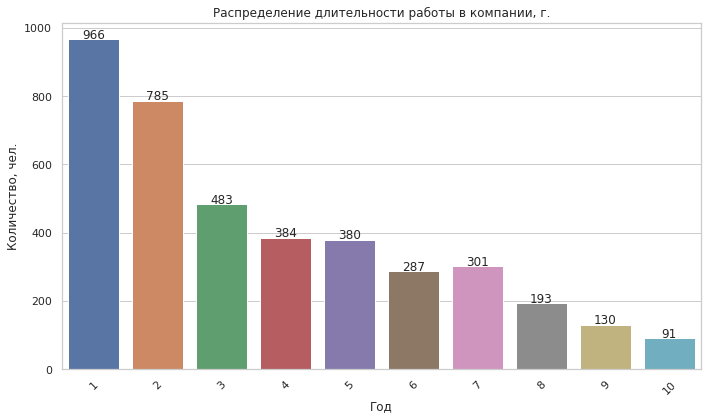

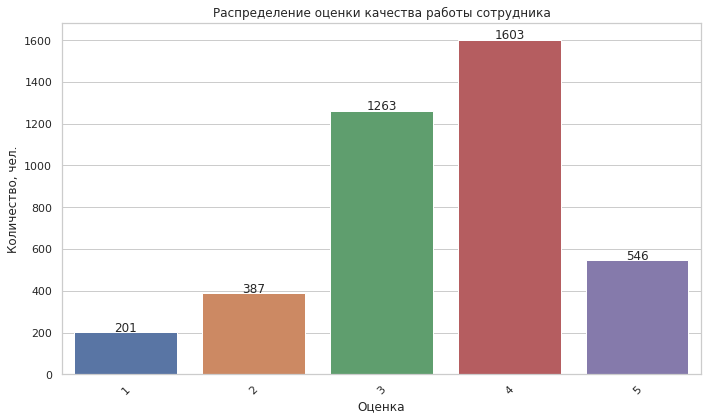

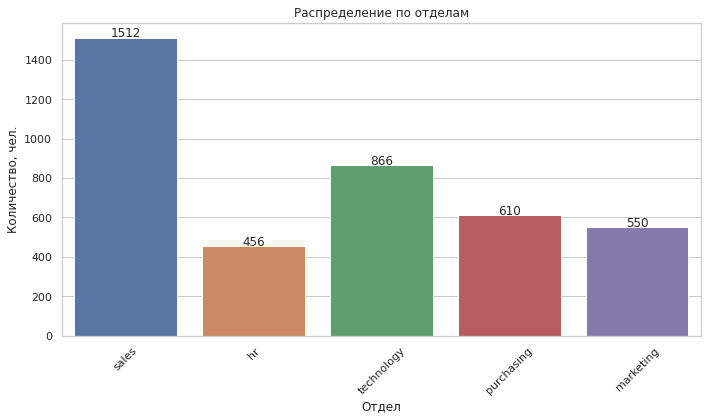

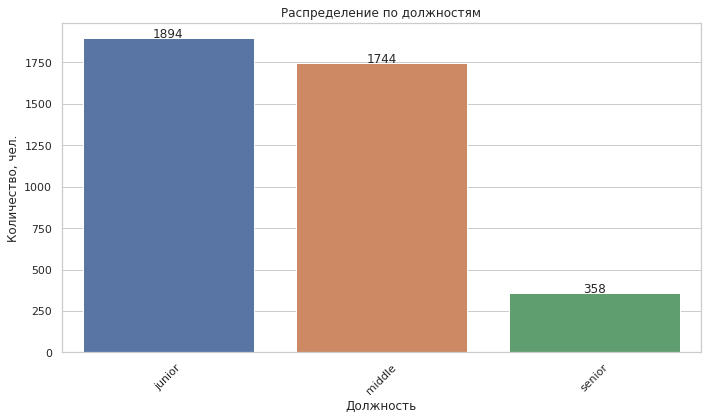

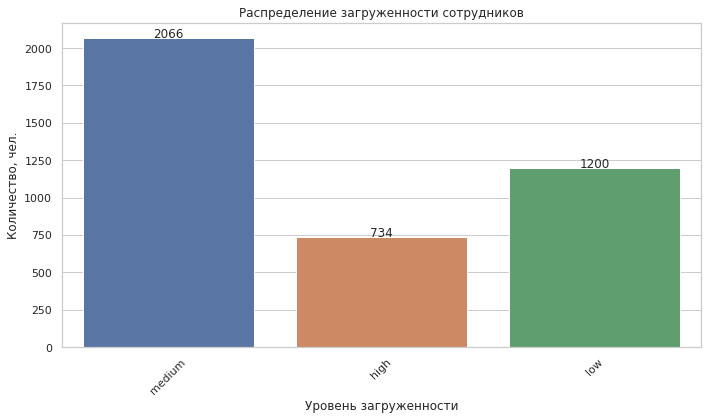

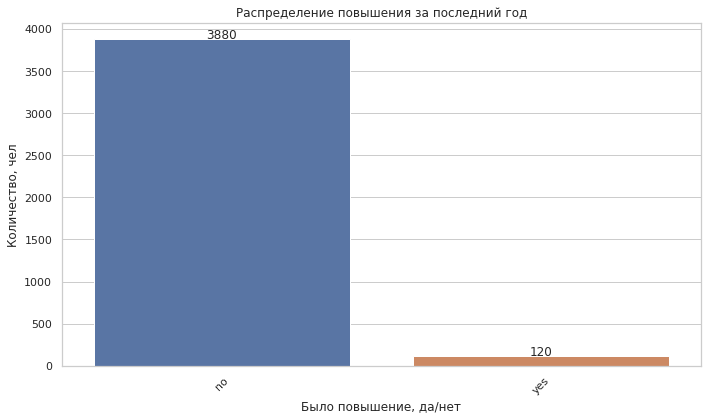

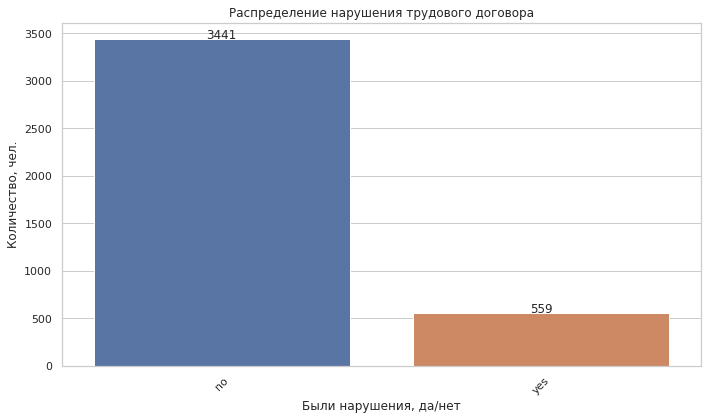

In [125]:
# Категориальные признаки
cat_cols = [
    'employment_years', 
    'supervisor_evaluation', 
    'dept', 
    'level', 
    'workload', 
    'last_year_promo', 
    'last_year_violations'
]

# Словарь с подписями для графиков
labels_dict = {
    'employment_years': ["Распределение длительности работы в компании, г.", "Год", "Количество, чел."], 
    'supervisor_evaluation': ["Распределение оценки качества работы сотрудника", "Оценка", "Количество, чел."],
    'dept': ["Распределение по отделам", "Отдел", "Количество, чел."],
    'level': ["Распределение по должностям", "Должность", "Количество, чел."],
    'workload': ["Распределение загруженности сотрудников", "Уровень загруженности", "Количество, чел."],
    'last_year_promo': ["Распределение повышения за последний год", "Было повышение, да/нет", "Количество, чел"],
    'last_year_violations': ["Распределение нарушения трудового договора", "Были нарушения, да/нет", "Количество, чел."]
}

# Построение графиков
for col in cat_cols:
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=train_job_satis, x=col)
    
    # Получаем подписи из словаря (если нет — используем значения по умолчанию)
    title, xlabel, ylabel = labels_dict.get(col, [f'"{col}"', col, 'Частота'])

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)

    # Числовые подписи над столбцами
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x() + p.get_width() / 2,
            y=height + 3.5,
            s=int(height),
            ha='center'
        )

    plt.tight_layout()
    plt.show()

Проведем корреляционный анализ признаков в количественной шкале в таблице train_job_satis для моделирования. Сделаем выводы о мультиколлинеарности и при необходимости устраним её.

   <br />
    <font color='4682B4'>Количественные признаки распределенны нормально со смещением. Оценим  корреляцию методом спирмана</font>
</div>

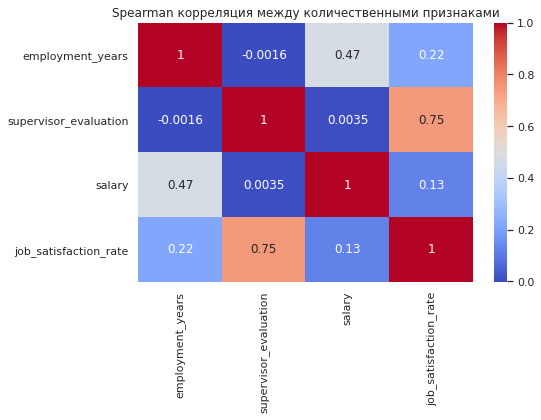

In [127]:
# 1. Корреляция между количественными признаками (коэффициент Спирмена)
num_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
spearman_corr = train_job_satis[num_cols].corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm')
plt.title('Spearman корреляция между количественными признаками')
plt.tight_layout()
plt.show()

   <br />
    <font color='4682B4'> В матрице корреляции, максимальное значение 0.75 (умеренная) между supervisor_evaluation и job_satisfaction_rate, далее значение 0.47 (умеренная) между employment_years и salary, 0.22 (слабая) между job_satisfaction_rate и employment_years. Мультиколлинеарности нет.</font>
</div>

<font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Спасибо за развернутые пояснения! Этого очень не хватает в такой форме обучения.</font>
</div>

In [128]:
# Входные признаки тестовой выборки:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [129]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [130]:
test_features.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


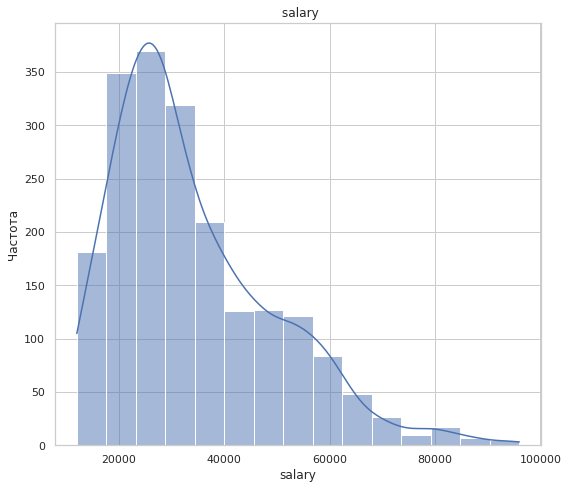

In [131]:
# построим графики для количественных признаков
num_cols = ['salary']

# Гистограммы с распределениями
plt.figure(figsize=(15, 13))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)          # 2 строки, 2 столбца
    sns.histplot(test_features[col], kde=True, bins=15)
    plt.title(f' {col}')
    plt.xlabel(col)  
    plt.ylabel('Частота')  
plt.tight_layout()
plt.show()

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

1. Визуализация id вероятно не несет бизнесового смысла?
    
2. Для визуализации дискретных признаков не следует использовать гистограмму.    
</div>

<font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>'id' и 'employment_years', 'supervisor_evaluation' убрал.</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

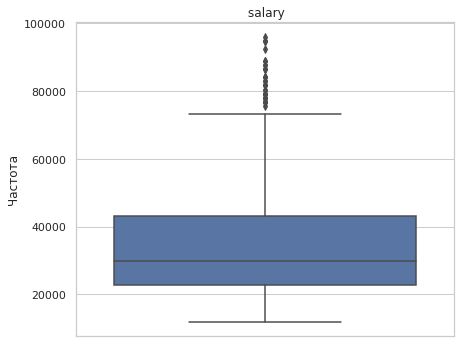

In [132]:
# ящики с усами с выбросами
plt.figure(figsize=(12, 14))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(y=test_features[col])
    plt.title(f' {col}')
    plt.ylabel('Частота')
plt.tight_layout()
plt.show()

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Для дискретных признаков "ящики с усами" не нужны, так как эти признаки имеют скорее распределение категориального признака, пусть и представленного в численном виде.
</div>


<font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Понял. Они копируют картину describe()</font>
</div>

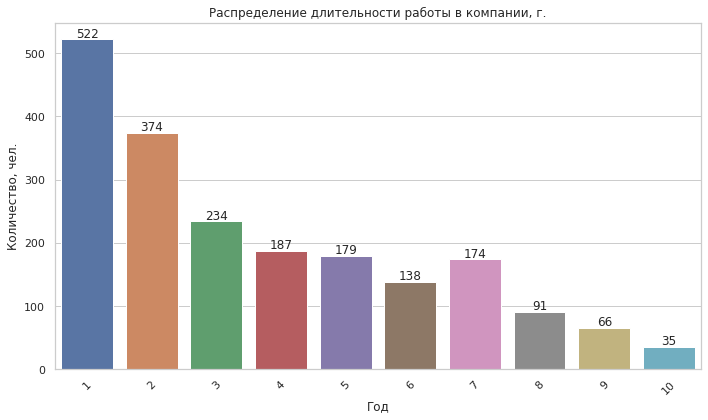

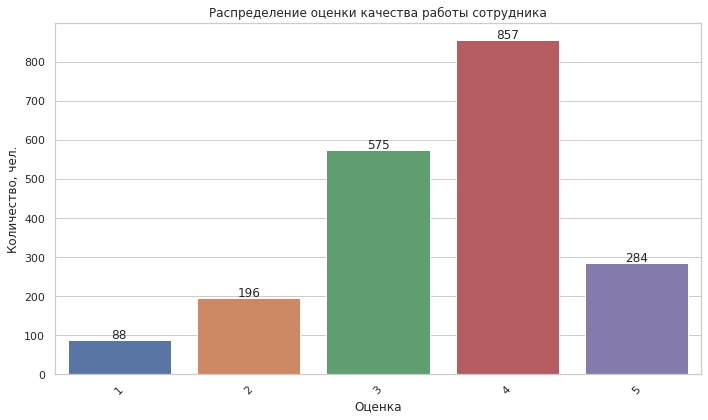

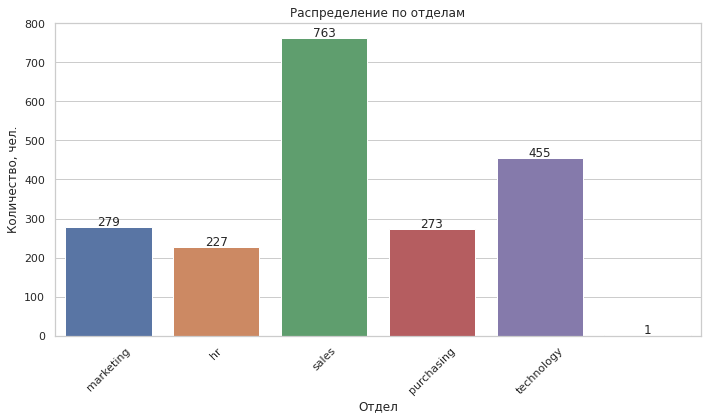

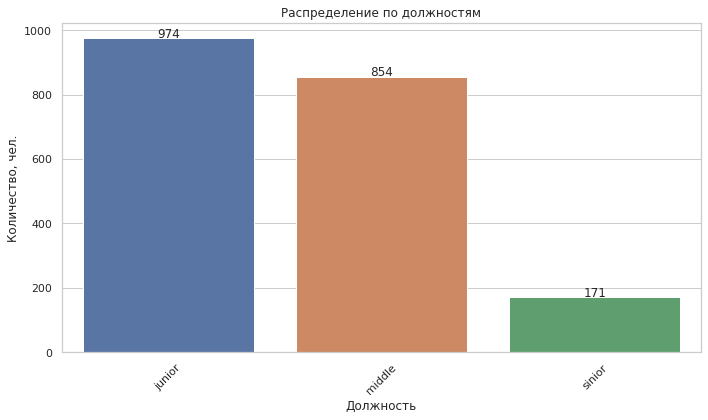

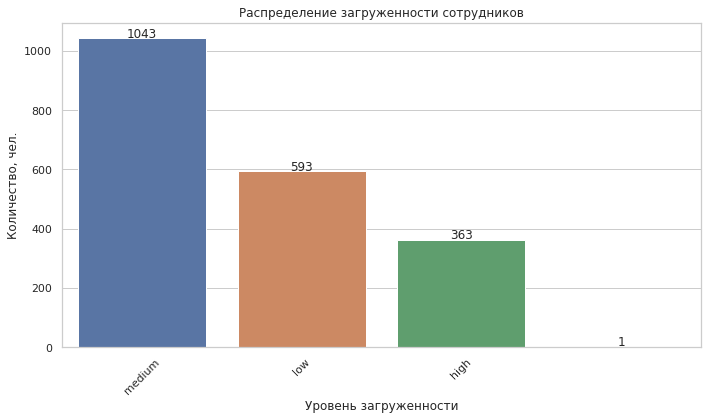

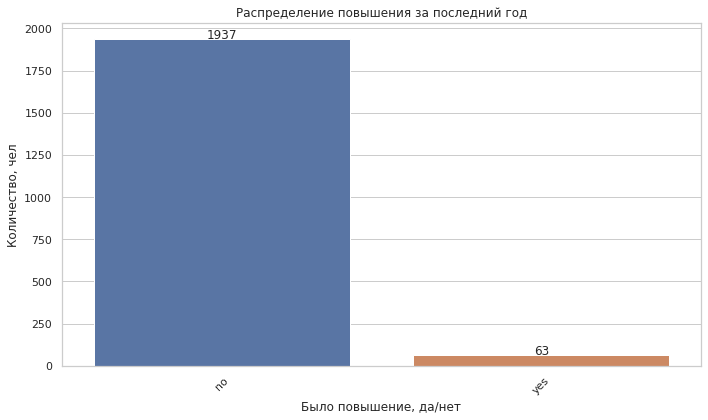

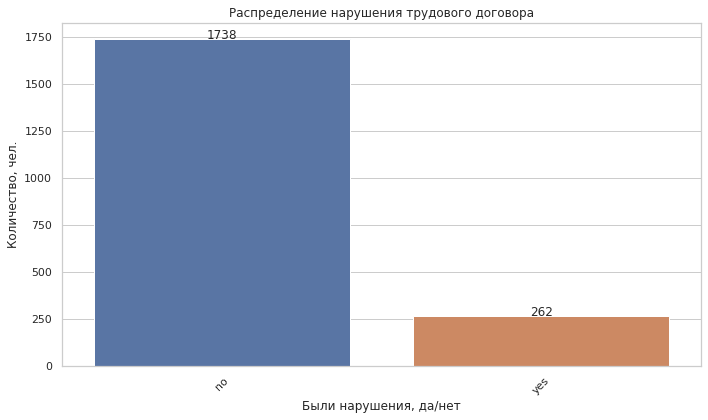

In [133]:
# Категориальные признаки
cat_cols = [
    'employment_years', 
    'supervisor_evaluation', 
    'dept', 
    'level', 
    'workload', 
    'last_year_promo', 
    'last_year_violations'
]

# Словарь с подписями для графиков
labels_dict = {
    'employment_years': ["Распределение длительности работы в компании, г.", "Год", "Количество, чел."], 
    'supervisor_evaluation': ["Распределение оценки качества работы сотрудника", "Оценка", "Количество, чел."],
    'dept': ["Распределение по отделам", "Отдел", "Количество, чел."],
    'level': ["Распределение по должностям", "Должность", "Количество, чел."],
    'workload': ["Распределение загруженности сотрудников", "Уровень загруженности", "Количество, чел."],
    'last_year_promo': ["Распределение повышения за последний год", "Было повышение, да/нет", "Количество, чел"],
    'last_year_violations': ["Распределение нарушения трудового договора", "Были нарушения, да/нет", "Количество, чел."]
}

# Построение графиков
for col in cat_cols:
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=test_features, x=col)
    
    # Получаем подписи из словаря (если нет — используем значения по умолчанию)
    title, xlabel, ylabel = labels_dict.get(col, [f'"{col}"', col, 'Частота'])

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)

    # Числовые подписи над столбцами
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x() + p.get_width() / 2,
            y=height + 3.5,
            s=int(height),
            ha='center'
        )

    plt.tight_layout()
    plt.show()


# # оценим категоральные признаки построив их графики
# cat_cols = test_features.select_dtypes(include=['object', 'category']).columns
# for col in cat_cols:
#     plt.figure(figsize=(10, 6))
#     ax = sns.countplot(data=test_features, x=col)  # сохраняем график в переменную ax
#     plt.title(f'"{col}"')
#     plt.ylabel('Частота')
#     plt.xticks(rotation=45)

#     # Добавим числовые подписи над столбцами
#     for p in ax.patches:
#         height = p.get_height()
#         ax.text(
#             x=p.get_x() + p.get_width() / 2,
#             y=height + 3.5,  # немного выше столбика
#             s=int(height),
#             ha='center'
#         )

#     plt.tight_layout()
#     plt.show()

In [134]:
# Целевой признак тестовой выборки
test_target_job_satis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [135]:
test_target_job_satis.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [136]:
test_target_job_satis.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


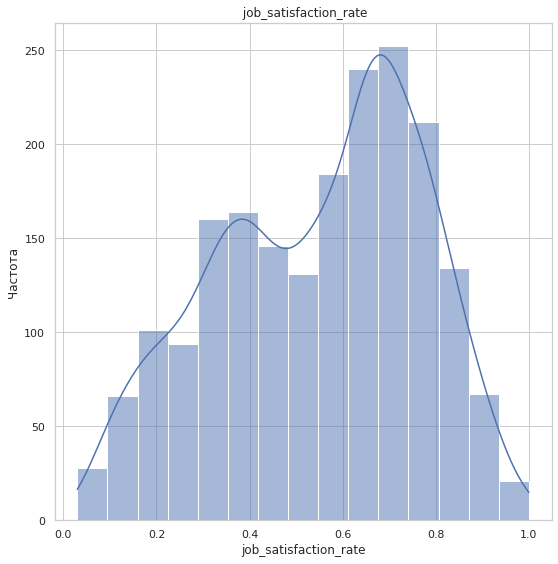

In [137]:
# построим графики для количественных признаков
num_cols = ['job_satisfaction_rate']

# Гистограммы с распределениями
plt.figure(figsize=(15, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 2, i)          
    sns.histplot(test_target_job_satis[col], kde=True, bins=15)
    plt.title(f' {col}')
    plt.xlabel(col)  
    plt.ylabel('Частота')  
plt.tight_layout()
plt.show()

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

Визуализация id вероятно не несет бизнесового смысла?
</div>

<font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>'id' удалил</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

Изучили и визуализировали данные в таблицах. Данные в норме, аномалий нет.

Проанализируем распределения признаков тренировочной выборки в зависимости от целевого признака (job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании).<br>
Чтобы анализировать зависимости признаков от удовлетворённости работой, сначала нужно превратить непрерывный признак job_satisfaction_rate в категориальный, например: "yes" (Удовлетворён) / "no" (Неудовлетворён).<br>
Для этого введем порог удовлетворенности "threshold". Из описания данных видно, что медиана целевого значения - 0.56, 75% квартиль - 0.71. Установим значение threshold = 0.6.<br>

In [138]:
# Порог удовлетворённости
threshold = 0.6
# Создание нового столбца 'satisfaction_level'
train_job_satis['satisfaction_level'] = train_job_satis['job_satisfaction_rate'].apply(
    lambda x: 'yes' if x >= threshold else 'no'
)

In [139]:
# Проверим баланс классов
train_job_satis['satisfaction_level'].value_counts(normalize=True)

no     0.542
yes    0.458
Name: satisfaction_level, dtype: float64

In [140]:
train_job_satis.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,satisfaction_level
0,155278,sales,junior,medium,2,no,no,1,24000,0.58,no
1,653870,hr,junior,high,2,no,no,5,38400,0.76,yes
2,184592,sales,junior,low,1,no,no,2,12000,0.11,no
3,171431,technology,junior,low,4,no,no,2,18000,0.37,no
4,693419,hr,junior,medium,1,no,no,3,22800,0.20,no


In [141]:
# # Количественный признак для визуализации
# features = [
#     'salary'
# ]

# # Построение гистограмм с hue='satisfaction_level'
# for col in features:
#     plt.figure(figsize=(8, 4))
#     sns.histplot(
#         data=train_job_satis,
#         x=col,
#         hue='satisfaction_level',
#         kde=True,
#         palette='Set1',
#         element='step',
#         stat='density'
#     )
#     plt.title(f'Распределение признака: {col}')
#     plt.grid(True)
#     plt.show()

<font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Поправка после ревьюV1</font>
</div>

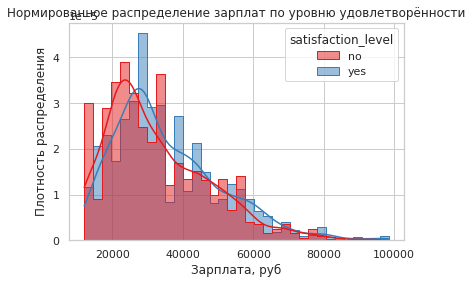

In [142]:
# Количественный признак для визуализации
# Пример для salary с разбивкой по уровню удовлетворённости
sns.histplot(
    data=train_job_satis,
    x='salary',
    hue='satisfaction_level',     # признак
    kde=True,                     # Добавляет ядерную оценку плотности
    palette='Set1',               # Цветовая схема
    element='step',               # Стиль отображения ("step", "bar", "poly")
    stat='density',               # Нормировка на плотность
    common_norm=False,            # Нормировка внутри каждой группы отдельно
    alpha=0.5                     # Прозрачность для лучшей визуализации
)
plt.title('Нормированное распределение зарплат по уровню удовлетворённости')
plt.xlabel('Зарплата, руб')
plt.ylabel('Плотность распределения')
plt.show()

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

Для визуализации дискретных признаков не следует использовать гистограмму.    
</div>

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>
    
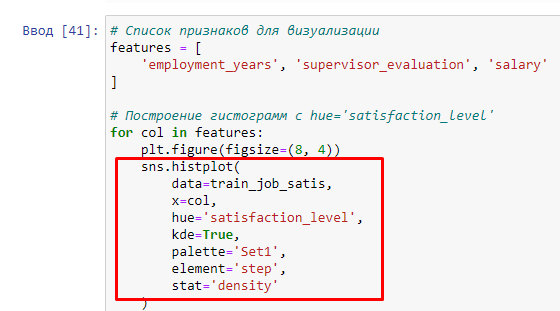    

Анализ нужно сделать с помощью относительных величин - оперировать абсолютными величинами не всегда удобно, так как в зависимости от масштаба исследования (компания на 100 человек и компания на 100 000 человек, например) результаты могут быть более или менее интерпретируемыми. Для категориальных/дискретных признаков мы можем использовать **value_counts(normalize=True)**, для непрерывных также стоит посчитать и сравнить средние.

**(ТЕОРИЯ) в зависимости от типа признака:**   
    
- Для анализа распределения **непрерывых величин** (у нас это например `salary`) стоит использовать нормированную гистограмму (например, `shs.histplot()` с параметрами `stat='density', common_norm=False` или `sns.kdeplot()`): гистограммы такого типа позволяют нивелировать разницу в размерах выборок при анализе распределений. Обрати также внимание, что при использовании нормированных гистограмм по оси Y будет уже не частота значений, а плотность распределения.

- Для анализа распределения **дискретных величин** (у нас это например `supervisor_evaluation` и `employment_years`) нужен тип графиков, который на каждое уникальные значение признака строит свою корзину. Например, можно использовать `sns.countplot` или `plot(kind='bar')`.
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Оба исправлены.
</div>

In [143]:
# # категориальные признаки
# cat_features = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

# for col in cat_features:
#     plt.figure(figsize=(8, 4))
#     sns.countplot(
#         data=train_job_satis,
#         x=col,
#         hue='satisfaction_level',
#         palette='Set1'
#     )
#     plt.title(f'Распределение признака: {col}')
#     plt.xticks(rotation=45)
#     plt.grid(True, axis='y')
#     plt.show()


<font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Корректировка графиков дискретных величин после ревью V1</font>
</div>

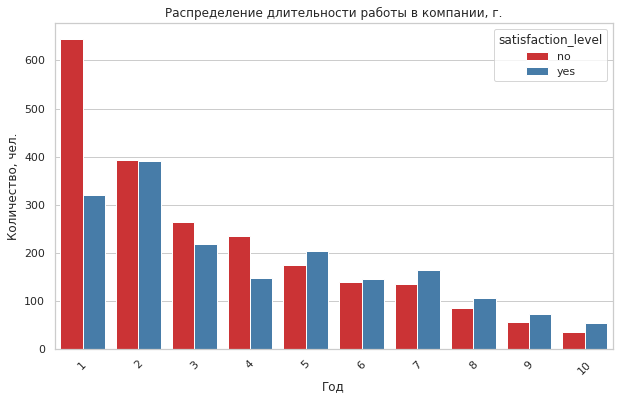

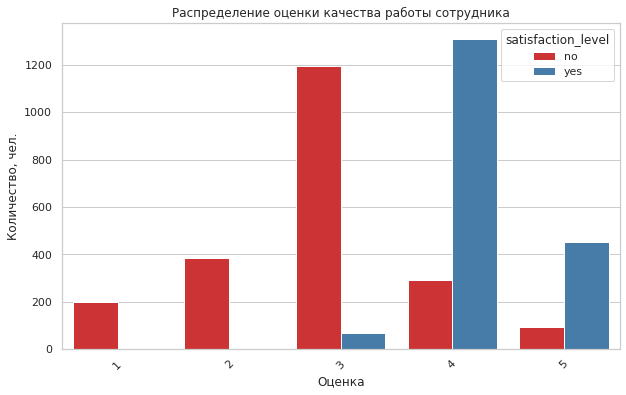

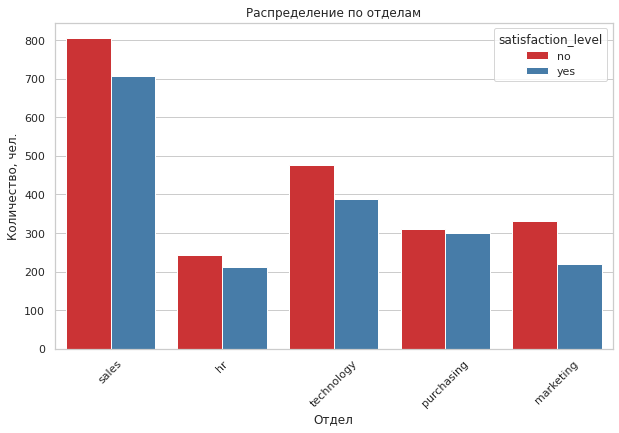

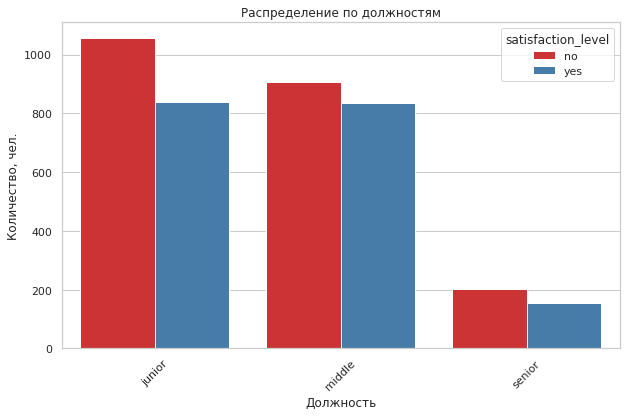

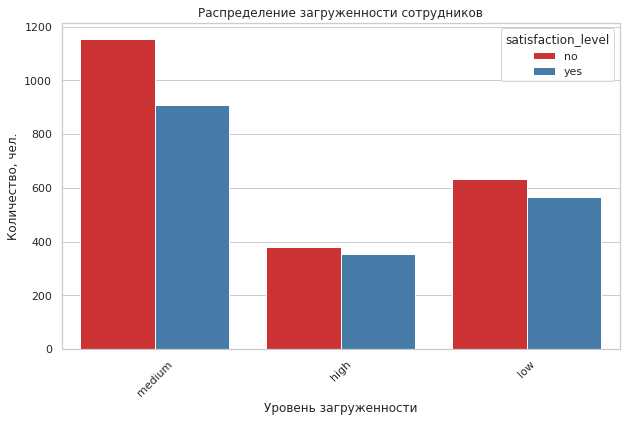

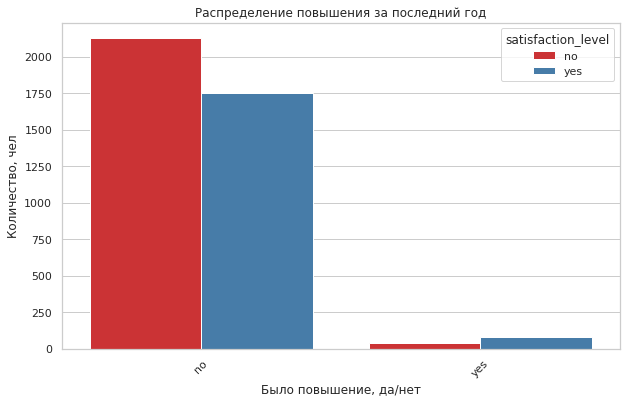

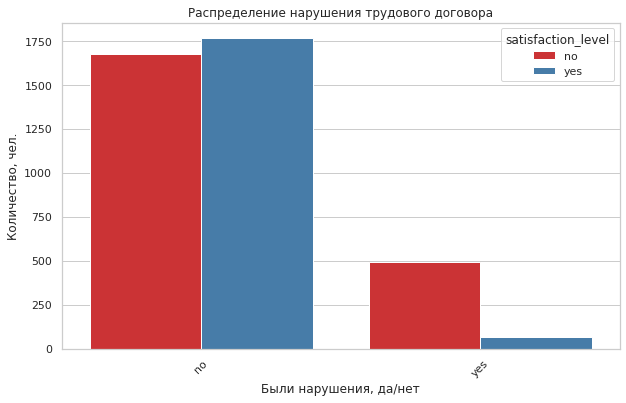

In [144]:
# Категориальные признаки
cat_cols = [
    'employment_years', 
    'supervisor_evaluation', 
    'dept', 
    'level', 
    'workload', 
    'last_year_promo', 
    'last_year_violations'
]

# Словарь с подписями для графиков
labels_dict = {
    'employment_years': ["Распределение длительности работы в компании, г.", "Год", "Количество, чел."], 
    'supervisor_evaluation': ["Распределение оценки качества работы сотрудника", "Оценка", "Количество, чел."],
    'dept': ["Распределение по отделам", "Отдел", "Количество, чел."],
    'level': ["Распределение по должностям", "Должность", "Количество, чел."],
    'workload': ["Распределение загруженности сотрудников", "Уровень загруженности", "Количество, чел."],
    'last_year_promo': ["Распределение повышения за последний год", "Было повышение, да/нет", "Количество, чел"],
    'last_year_violations': ["Распределение нарушения трудового договора", "Были нарушения, да/нет", "Количество, чел."]
}

# Построение графиков
for col in cat_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(
        data=train_job_satis,
        x=col,
        hue='satisfaction_level',
        palette='Set1'
    )
    
    # Получаем подписи из словаря (если нет — используем значения по умолчанию)
    title, xlabel, ylabel = labels_dict.get(col, [f'"{col}"', col, 'Частота'])

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.show()
    

</font><font color='Blue'><b>Вывод по исследовательскому анализу</b></font><br>
Провели дальнейший анализ и визуализации для таблиц train_job_satis, test_features и 
test_target_job_satis.  Данные в норме, аномалий нет.<br>

Построили матрицу корреляции для тренировочной выборки train_job_satis. <br>
В матрице корреляции, максимальное значение 0.69 (умеренная) между supervisor_evaluation и 
job_satisfaction_rate, далее значение 0.46 (умеренная) между employment_years и salary, 
0.21 (слабая) между job_satisfaction_rate и employment_years. Мультиколлинеарности нет.<br>

Для построения портрета удовлетворенности сотрудника проанализировали распределения признаков 
тренировочной выборки в зависимости от целевого признака (job_satisfaction_rate — уровень 
удовлетворённости сотрудника работой в компании). Установили порог удовлетворенности threshold = 0.6,
для перевода непрерывных значений целевого признака в категоральный ('yes'/'no').<br>

Балланс классов: "no" - 0.542, "yes" - 0.458. Учтем это в аналитике графиков.<br>

Количественные признаки: <br>

Признак "employment_years" (длительность работы в компании, в годах). До 4 лет включительно заметно 
преобладание группы "no", особенно это заметно при длительности 1 год, группа "no" в два раза больше 
чем группа "yes". При значении 2 года, группы практически одинаковы. Начиная с 5 лет, группа "yes" 
немного доминирует.<br>
Признак "supervisor_evaluation" (оценка качества работы сотрудника, которую дал руководитель). Оценки
1, 2 и 3 принадлежат группе "no". Очень редко оценку 3 получает группа "yes". Оценку 4 в основном имеет группа "yes", она примерно в 5 раз больше группы "no" здесь. Примерно такая картина и в оценке 5.<br>
Признак "salary" (ежемесячная зарплата сотрудника). Здесь примерно до 30 000, преобладает группа "no", после этой суммы обе группы имеют похожее распределение.<br>

Категоральные признаки:<br>

Признак "dept" (отдел, в котором работает сотрудник). Группы "no" и "yes" здесь распределены примерно 
одинаково, небольшое преобладание имеет группа "no" по всем отделам. Наименьшая разница наблюдается в 
отделе "purchasing" (снабжение) и "hr".<br>
Признаки "level" (уровень занимаемой должности) и "workload" (уровень загруженности сотрудника) имеют
такую же картину, группы "no" и "yes" здесь распределены примерно одинаково, небольшое преобладание 
имеет группа "no" по всем отделам. <br>
Признак "last_year_promo" (было ли повышение за последний год) имеет два значения no и yes 
(было повышение). В основном данные сосредоточенны в значении no, и там немного преобладает группа 
"no". В данных, которые содержат значение yes (было повышение), примерно в два раза преобладает 
группа "yes".<br>
Признак "last_year_violations" (нарушал ли сотрудник трудовой договор за последний год) имеет два 
значения no и yes соответственно. Основная часть данных находится в значении no (не нарушал) и в нем
значения групп примерно одинако, с небольшим преобладанием группы "yes". В данных, которые содержат 
значение yes (было нарушение), примерно в 6 раз преобладает группа "no" 
(которая соответственно неудовлетворена работой).  <br>

Портрет удовлетворённого сотрудника (job_satisfaction_rate ≥ 0.6, категория = "yes")<br>

Количественные признаки:<br>

Опыт в компании (employment_years): Удовлетворённые сотрудники чаще работают в компании 5 лет и более. Среди новичков с 1 годом стажа заметно больше неудовлетворённых.<br>
Оценка руководителя (supervisor_evaluation): Высокая оценка от руководства — ключевой фактор удовлетворённости. Оценка 4 и 5 значительно преобладает у довольных сотрудников. Оценки 1–3 почти полностью принадлежат неудовлетворённым.<br>
Зарплата (salary): При зарплате до 30 000 доминируют неудовлетворённые. При более высоких зарплатах — распределение сбалансировано.<br>

Категориальные признаки:<br>

Повышение за последний год (last_year_promo): Среди сотрудников, получивших повышение, примерно в 2 раза больше удовлетворённых. Повышение — сильный мотиватор.<br>
Нарушения трудового договора (last_year_violations): При наличии нарушений преобладают неудовлетворённые (примерно в 6 раз). Нарушения могут быть следствием недовольства, а не только его причиной.<br>
Отдел (dept), уровень должности (level), загруженность (workload): Существенных различий между удовлетворёнными и неудовлетворёнными нет, небольшое преимущество везде за группой "no".<br>

Вывод:<br>

Удовлетворённый сотрудник — это, как правило:<br>

Имеет стаж 5+ лет<br>
Получил оценку 4–5 от руководителя<br>
Зарабатывает выше 30 000<br>
Недавно был повышен<br>
Не нарушал правила компании<br>

Низкая удовлетворённость чаще встречается у:<br>

Новичков (1 год)<br>
С низкой зарплатой<br>
С оценкой ≤ 3<br>
Без повышения<br>
С историей нарушений<br>

<font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>V1 В выводе слабо изменятся данные по корреляции.
В матрице корреляции, максимальное значение 0.75 (умеренная) между supervisor_evaluation и job_satisfaction_rate, далее значение 0.47 (умеренная) между employment_years и salary, 0.22 (слабая) между job_satisfaction_rate и employment_years. Мультиколлинеарности нет.</font>
</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Данные загружены, отлично.

Хорошо, что применяешь метод .head()/.sample() таким образом в память не будет загружен весь датасет, объем которого может быть огромным.

Методы .info, .describe, .value_counts(), .unique() как правило часто встречаются и обязательны к применению в задачах по исследованию данных, ведь с их помощью можно получить первые инсайты. 

Итак, мы провели предварительный анализ данных, проверили данные на наличие пропусков и затем обработали их (аргументированно заполнили / удалили / оставили как есть). Провели графический анализ. Сделали и озвучили выводы. Теперь можно приступать собственно к моделированию и ответам на вопросы проекта.

</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>


**Этот шаг спасет твою аналитику (и карьеру):** классический кейс - к аналитику (неважно: DA-аналитику, DS-аналитику, ML-инженеру) прибегает его начальник с горящими глазами: «Срочно нужно посчитать метрики, отчет нужен вчера, Я ЖДУУУУУУУУ!!!!!!!!!!!!!!!!!!!!!!». Аналитик лезет в сырые данные, быстро собирает дашборд … и всё. Ни тебе проверки распределений, ни поиска выбросов, ни визуализации. Начальник на следующий день презентует эти цифры как истину в последней инстанции. А потом на них строятся бизнес-решения стоимостью десятки-сотни миллионов рублей … 

<br>
<br>
<details>
<summary style="color: blue; font-size: 18px; font-weight: bold;">▶ <u>ТАК ДЕЛАТЬ НЕЛЬЗЯ! НИКОГДА!!!</u></summary>

Исследовательский анализ данных (EDA — Exploratory Data Analysis) — это первый и обязательный шаг перед тем, как ты начнёшь считать метрики, строить модели или делать выводы. Он помогает понять, с чем ты на самом деле работаешь, выявить ошибки и аномалии, а самое главное, не попасть в ловушку красивых, но ложных цифр.

Особенно критично это в машинном обучении. Когда ты обучаешь модель на плохих данных, хороший результат невозможен в принципе. В этом смысле работает железное правило: garbage in — garbage out.

Что входит в EDA?

✔️ Осмотр данных. Сколько строк? Какие типы колонок? Что выглядит странно? Уже на этом этапе можно поймать очевидные ошибки. Используй .info(), .describe(), загляни в начало и конец таблицы, проверь типы.

✔️ Пропуски и дубликаты. Пропуски не всегда нужно удалять — иногда лучше заполнить их медианой, модой или предсказанными значениями. А дубликаты — это не только точные копии строк. Часто бывают неявные: например, у одного пользователя два одинаковых заказа с разными ID.

✔️ Очистка и предобработка. Проверка категориальных значений, работа с форматами, единообразие записи. Например, если у тебя в колонке есть и «Санкт-Петербург» и «СПБ» и «Питер», то без нормализации это три разных значения. А если даты хранятся как строки — ты не сможешь нормально их анализировать.

✔️ Выбросы и аномалии. Просто посчитать среднее недостаточно. Построй распределение, используй boxplot. Эти графики мгновенно покажут, где данные выбиваются за границы нормы. И не забывай: один выброс может испортить тебе весь анализ.

✔️ Визуализация. Даже простой scatter plot может рассказать тебе гораздо больше, чем набор агрегатов. Иногда взаимосвязь между переменными становится очевидной только когда ты её увидишь, а не посчитаешь.

EDA — это не про «поковыряться в данных». Это про понять, что ты анализируешь, и быть уверенным в своих выводах. Это защита от ошибок, которые ты даже не успел заметить.

Теперь давай разберём первый и самый недооценённый шаг в исследовательском анализе: осмотр данных.

Представь, что ты лезешь в базу и ... сразу пишешь groupby() или строишь график? Это ловушка. Начинать нужно не с расчётов, а с банального знакомства с тем, что у тебя вообще в руках. Осмотр данных — это как включить свет в темной комнате. Сразу видно, где пыльно, а где стоит тумбочка, об которую легко споткнуться.

Первым делом смотри на объем данных: df.shape покажет, сколько строк и колонок. Иногда там вообще пара десятков строк — и это уже повод позвать дата-инженера. 
Дальше — названия колонок. Через df.columns можно заметить лишние пробелы, странные символы, дубли названий. Здесь же удобно сразу стандартизировать названия: убрать русские слова и привести к единому стилю ("snake_case" ван лав). Такие вещи не бросаются в глаза, но потом ломают пайплайн.

Теперь — в бой идет df.info(). Это твой лучший друг. Он покажет:

▪️какие типы данных у колонок,
▪️сколько ненулевых значений,
▪️сколько памяти жрёт датафрейм.

Обрати внимание: если в колонке написано, что у неё 80 000 непустых значений, а в df.shape[0] у тебя 100 000 — значит, 20% пропусков. Это серьёзно. 
Ещё один лайфхак: если колонка выглядит пустой, но info() говорит, что там всё заполнено — проверь, не строки ли там вроде " " или "None". Это визуальные, а не настоящие пропуски. Так что df.replace() тебе в помощь.

Если всё типы данных соответствуют ожиданиям — отлично. Если нет — можно наткнуться на неприятности. Например, object вместо чисел или дат — и ты не сможешь нормально группировать, фильтровать, делить на категории. В таких случаях сразу меняй тип или уточняй источник.

Следом подключай df.describe(). Это быстрый способ понять, как «живут» числовые данные. Сравни среднее и медиану — это может подсветить асимметричное распределение. Проверь минимум и максимум — там часто сидят выбросы или ошибки: отрицательные значения там, где их быть не должно, нули в колонке с деньгами, тысячи категорий у рейтинга от 1 до 5.

Дополнительно пригодится .nunique(): иногда колонка кажется категориальной, а там каждый второй элемент уникален. Это уже почти ID, и скорее всего — не то, что ты хотел анализировать.

И не забывай смотреть глазами. df.head(), df.tail() — быстрый способ поймать неявные проблемы. Например, даты, которые лежат строками. Или списки внутри ячеек. Или дубли с разницей в один символ. В табличке может быть много неожиданного — особенно если её собирали в два этапа, три человека, а выгружал четвёртый.

Осмотр данных — это про внимательность и здравый смысл. Здесь ты ловишь грубые баги, структурные проблемы и мусор, который может незаметно утащить твою аналитику не туда. А ещё — экономишь себе кучу времени, потому что не придется всё переделывать после того, как уже построен отчёт.

*Информация из канала: t.me/thisisdata*
</details>
<br>
<br>
</div>


<font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Спасибо за допинфо!</font>
</div>

### Шаг 4. Подготовка данных и Шаг 5. Обучение моделей

In [145]:
# Копируем данные
train = train_job_satis.copy()
test = test_features.copy()

# Отделяем признаки и целевую переменную для обучения
X = train.drop(columns=['id', 'satisfaction_level', 'job_satisfaction_rate'], errors='ignore')
y = train['job_satisfaction_rate']

# --- Правильное объединение тестовых данных ---

# Объединяем по 'id', чтобы корректно сопоставить признаки и таргет
test_merged = pd.merge(
    test,
    test_target_job_satis[['id', 'job_satisfaction_rate']],
    on='id',
    how='inner'
)

# Отделяем признаки и целевую переменную
X_test = test_merged.drop(columns=['id', 'job_satisfaction_rate'])
y_test = test_merged['job_satisfaction_rate']

# Проверка длины
assert len(X_test) == len(y_test), "Длины X_test и y_test не совпадают!"

# Обновляем списки признаков
num_features = ['employment_years', 'supervisor_evaluation', 'salary']
cat_ordinal_features = ['level', 'last_year_promo', 'last_year_violations']
cat_nominal_features = ['dept', 'workload']

# Пайплайны для признаков
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_ordinal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[
        ['junior', 'middle', 'senior'],
        ['no', 'yes'],   # 'last_year_promo'              
        ['no', 'yes']    # 'last_year_violations'
    ],
    handle_unknown='use_encoded_value',
    unknown_value=-1
    ))                           
])

cat_nominal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('ord', cat_ordinal_transformer, cat_ordinal_features),
    ('nom', cat_nominal_transformer, cat_nominal_features)
])

# Отбор признаков
feature_selector = SelectKBest(score_func=f_regression, k='all')

# Словарь моделей
models = {
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42)
}

# Параметры для GridSearch
param_grids = {
    'Ridge': {'model__alpha': [0.1, 1.0, 10.0]},
    'Decision Tree': {'model__max_depth': [3, 5, 10], 'model__min_samples_leaf': [1, 5, 10]},
    'Random Forest': {'model__n_estimators': [50], 'model__max_depth': [5]},
    'HistGradientBoosting': {'model__max_iter': [100], 'model__max_depth': [5]}
}

# Функция для SMAPE
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    return np.mean(diff) * 100

best_model_name = None
best_model = None
best_cv_score = float('inf')

# Поиск лучшей модели
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('selector', feature_selector),
        ('model', model)
    ])
    grid = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='neg_mean_absolute_error')
    grid.fit(X, y)
    cv_score = -cross_val_score(grid.best_estimator_, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
    print(f"Средняя MAE {name}: {cv_score:.2f}")  
    if cv_score < best_cv_score:                 
        best_cv_score = cv_score
        best_model_name = name
        best_model = grid.best_estimator_

print(f"Лучшая модель по валидации: {best_model_name}")

# Предсказание и оценка на тесте
y_pred_test = best_model.predict(X_test)
smape_test = smape(y_test, y_pred_test)

print(f"SMAPE на тестовой выборке ({best_model_name}): {smape_test:.2f}")

if smape_test <= 15:
    print("Успех: SMAPE на тесте ≤ 15")
else:
    print("SMAPE на тесте превышает порог — стоит доработать признаки или модель")


Средняя MAE Ridge: 0.10
Средняя MAE Decision Tree: 0.06
Средняя MAE Random Forest: 0.08
Средняя MAE HistGradientBoosting: 0.05
Лучшая модель по валидации: HistGradientBoosting
SMAPE на тестовой выборке (HistGradientBoosting): 13.11
Успех: SMAPE на тесте ≤ 15


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично! Таргеты теста объединяются с фичами теста по id!

В данные тестовой выборки добавлен целевой признак. И добавлен верно - объединение выполнено по id.

</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>



OrdinalEncoder у тебя настроен на работу с неизвестными категориями.
</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>



OneHotEncoder у тебя настроен на работу с неизвестными категориями. Это гарантия того, что твой код "не упадет" когда встретит (например в проде) значение, которое он (код) не видел на этапе обучения модели! ОТЛИЧНО!

p.s. параметра **drop='first'** НЕ ДОЛЖНО быть рядом с **handle_unknown='ignore'**. При их одновременном использовании будет наблюдаться следующая проблема:  и пропущенная (dropped) первая категория, и любые неизвестные категории будут кодироваться одинаково - вектором из всех нулей. Соответственно станет невозможным различить их после трансформации признаков. Убери пожалуйста **drop='first'**, оставь **handle_unknown='ignore'**

</div>

  <br />
    <font color='4682B4'>после отмены исправления данных в тестовой выборке, SMAPE получился 13.11. В OrdinalEncoder добавил handle_unknown='use_encoded_value' и задать unknown_value=-1 (если встретится неизвестная категория (например, опечатка 'sinior'), она будет закодирована как -1, чтобы не вызвать ошибку при трансформации.). После ревью V1</font>
</div>

</font><font color='Blue'><b>Выводы по поиску модели</b></font><br>
Лучшей моделью по метрике "MAE" оказалась "HistGradientBoosting": со значением 0.05. Модель "Decision Tree": со значением метрики "MAE" 0.06 расположилась на втором месте.<br>
Для окончального выбора модели использовалась метрика "SMAPE", ее значение у модели должно быть ниже или равно 15. "HistGradientBoosting" справилась с этим, ее значение получилось 11.60.<br>
При решении выбора модели была проблема при расчете "SMAPE", на тестовых данных она оказывалась около 49. Ошибка была в разной индексации порядка "id" в таблицах test_features и test_target_job_satis. Объединение этих таблиц по "id" решило проблему и метрика "SMAPE" начала корректно работать.<br>
При решении использвали пайплайн и 4 модели: <br>
'Ridge' (Гребневая регрессия), линейная модель с L2-регуляризацией, минимизирует MSE + штраф за большие веса. <br>
'Decision Tree' (Дерево решений), рекурсивно разбивает данные по условиям на признаки.<br>
'Random Forest' (Случайный лес), ансамбль из множества деревьев с бэггингом и случайным выбором признаков.<br>
'HistGradientBoosting' (Градиентный бустинг), последовательное построение деревьев, где каждое новое исправляет ошибки предыдущих. Оптимизированная реализация от scikit-learn.<br>
Отбор признаков проводили с помощью SelectKBest - выбирает K наиболее информативных признаков на основе статистической зависимости между каждым признаком и целевой переменной.<br>
Лучшую модель выбирали по кросс валидации с метрокой 'neg_mean_absolute_error' - это отрицательная средняя абсолютная ошибка (MAE). Знак "-" ставится потому что GridSearchCV и cross_val_score всегда максимизируют метрики. А MAE нужно минимизировать. Поэтому sklearn берёт отрицательное значение MAE, чтобы его можно было "максимизировать".<br>

### Задача 2: Предсказание увольнения сотрудника из компании. Шаг 1. Загрузка данных
Для этой задачи те же входные признаки, что и в предыдущей. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

In [146]:
# Тренировочная выборка:
train_quit = pd.read_csv('/datasets/train_quit.csv')
# Входные признаки тестовой выборки те же, что и в прошлой задаче:
test_features_quit = pd.read_csv('/datasets/test_features.csv')  
# Целевой признак тестовой выборки:
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')  

### Задача 2. Шаг 2. Предобработка данных
Изучим данные

In [147]:
# Тренировочная выборка:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [148]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [149]:
# дубликаты
train_quit.duplicated().sum()

0

In [150]:
# оценим неявные дубликаты, изучив уникальные значения строковых колонок
cols_to_check = ['id', 'dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']

for col in cols_to_check:
    print(f"\n--- Уникальные значения в колонке '{col}': ---")
    print(train_quit[col].unique())
    print(f"Всего уникальных значений: {train_quit[col].nunique()}")


--- Уникальные значения в колонке 'id': ---
[723290 814010 155091 ... 536432 692133 853842]
Всего уникальных значений: 4000

--- Уникальные значения в колонке 'dept': ---
['sales' 'purchasing' 'marketing' 'technology' 'hr']
Всего уникальных значений: 5

--- Уникальные значения в колонке 'level': ---
['middle' 'junior' 'sinior']
Всего уникальных значений: 3

--- Уникальные значения в колонке 'workload': ---
['high' 'medium' 'low']
Всего уникальных значений: 3

--- Уникальные значения в колонке 'last_year_promo': ---
['no' 'yes']
Всего уникальных значений: 2

--- Уникальные значения в колонке 'last_year_violations': ---
['no' 'yes']
Всего уникальных значений: 2

--- Уникальные значения в колонке 'quit': ---
['no' 'yes']
Всего уникальных значений: 2


In [151]:
# исправим опечатку в level
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')

In [152]:
# проверим
cols_to_check = ['id', 'dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']

for col in cols_to_check:
    print(f"\n--- Уникальные значения в колонке '{col}': ---")
    print(train_quit[col].unique())
    print(f"Всего уникальных значений: {train_quit[col].nunique()}")


--- Уникальные значения в колонке 'id': ---
[723290 814010 155091 ... 536432 692133 853842]
Всего уникальных значений: 4000

--- Уникальные значения в колонке 'dept': ---
['sales' 'purchasing' 'marketing' 'technology' 'hr']
Всего уникальных значений: 5

--- Уникальные значения в колонке 'level': ---
['middle' 'junior' 'senior']
Всего уникальных значений: 3

--- Уникальные значения в колонке 'workload': ---
['high' 'medium' 'low']
Всего уникальных значений: 3

--- Уникальные значения в колонке 'last_year_promo': ---
['no' 'yes']
Всего уникальных значений: 2

--- Уникальные значения в колонке 'last_year_violations': ---
['no' 'yes']
Всего уникальных значений: 2

--- Уникальные значения в колонке 'quit': ---
['no' 'yes']
Всего уникальных значений: 2


train_quit имеет 10 колонок, 4000 строк, пропусков нет. Типы данных соответствуют значениям. 
Дубликатов нет. Исправили опечатку в level. Уникальные значения строковых колонок в порядке.

In [153]:
# Входные признаки тестовой выборки
test_features_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [154]:
test_features_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [155]:
# дубликаты
test_features_quit.duplicated().sum()

0

In [156]:
# оценим неявные дубликаты, изучив уникальные значения колонок
cols_to_check = ['id', 'dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

for col in cols_to_check:
    print(f"\n--- Уникальные значения в колонке '{col}': ---")
    print(test_features_quit[col].unique())
    print(f"Всего уникальных значений: {test_features_quit[col].nunique()}")


--- Уникальные значения в колонке 'id': ---
[485046 686555 467458 ... 305653 160233 771859]
Всего уникальных значений: 2000

--- Уникальные значения в колонке 'dept': ---
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Всего уникальных значений: 6

--- Уникальные значения в колонке 'level': ---
['junior' 'middle' 'sinior' nan]
Всего уникальных значений: 3

--- Уникальные значения в колонке 'workload': ---
['medium' 'low' 'high' ' ']
Всего уникальных значений: 4

--- Уникальные значения в колонке 'last_year_promo': ---
['no' 'yes']
Всего уникальных значений: 2

--- Уникальные значения в колонке 'last_year_violations': ---
['no' 'yes']
Всего уникальных значений: 2


In [159]:
# проверим
cols_to_check = ['id', 'dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

for col in cols_to_check:
    print(f"\n--- Уникальные значения в колонке '{col}': ---")
    print(test_features_quit[col].unique())
    print(f"Всего уникальных значений: {test_features_quit[col].nunique()}")


--- Уникальные значения в колонке 'id': ---
[485046 686555 467458 ... 305653 160233 771859]
Всего уникальных значений: 2000

--- Уникальные значения в колонке 'dept': ---
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Всего уникальных значений: 6

--- Уникальные значения в колонке 'level': ---
['junior' 'middle' 'sinior' nan]
Всего уникальных значений: 3

--- Уникальные значения в колонке 'workload': ---
['medium' 'low' 'high' ' ']
Всего уникальных значений: 4

--- Уникальные значения в колонке 'last_year_promo': ---
['no' 'yes']
Всего уникальных значений: 2

--- Уникальные значения в колонке 'last_year_violations': ---
['no' 'yes']
Всего уникальных значений: 2


  <br />
    <font color='4682B4'> test_features_quit имеет 9 колонок, 2000 строк, есть пропуски в dept, level. Типы данных соответствуют значениям. Дубликатов нет. Уникальные значения строковых колонок в порядке.</font>
</div>

In [160]:
# Целевой признак тестовой выборки:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [161]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [162]:
test_target_quit.duplicated().sum()

0

In [163]:
# уникальные значения
cols_to_check = ['id', 'quit']

for col in cols_to_check:
    print(f"\n--- Уникальные значения в колонке '{col}': ---")
    print(test_target_quit[col].unique())
    print(f"Всего уникальных значений: {test_target_quit[col].nunique()}")


--- Уникальные значения в колонке 'id': ---
[999029 372846 726767 ... 746018 247658 460332]
Всего уникальных значений: 2000

--- Уникальные значения в колонке 'quit': ---
['yes' 'no']
Всего уникальных значений: 2


test_target_quit имеет 2 колонки, 2000 строк, пропусков нет. Типы данных соответствуют значениям. 
Дубликатов нет. Исправили опечатку в level. Уникальные значения строковых колонок в порядке.

### Задача 2. Шаг 3. Исследовательский анализ данных
Проведем исследовательский анализ данных.<br>
Составим портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.<br>
Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируем и сравним распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используем данные с обоими целевыми признаками тестовой выборки.<br>

In [164]:
# Тренировочная выборка:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [165]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [166]:
# оценим количественные значения
train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


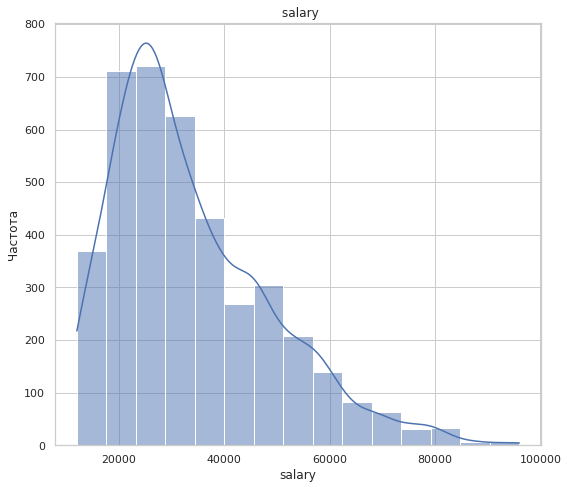

In [167]:
# построим графики для количественных признаков
num_cols = ['salary']

# Гистограммы с распределениями
plt.figure(figsize=(15, 13))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)         
    sns.histplot(train_quit[col], kde=True, bins=15)
    plt.title(f' {col}')
    plt.xlabel(col)  
    plt.ylabel('Частота')  
plt.tight_layout()
plt.show()

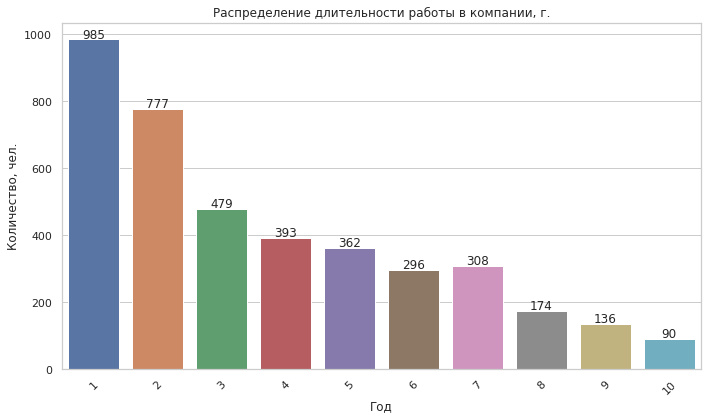

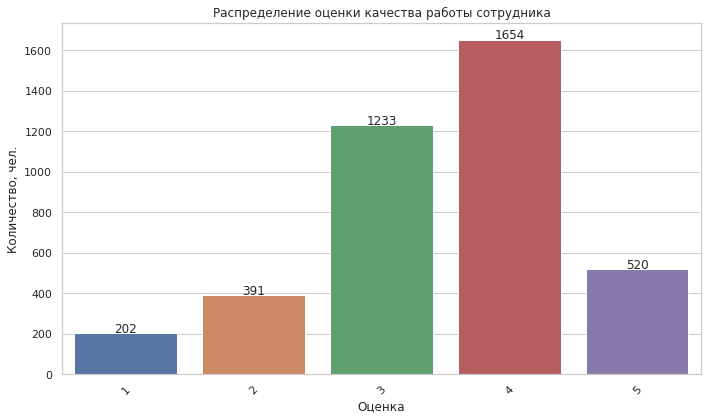

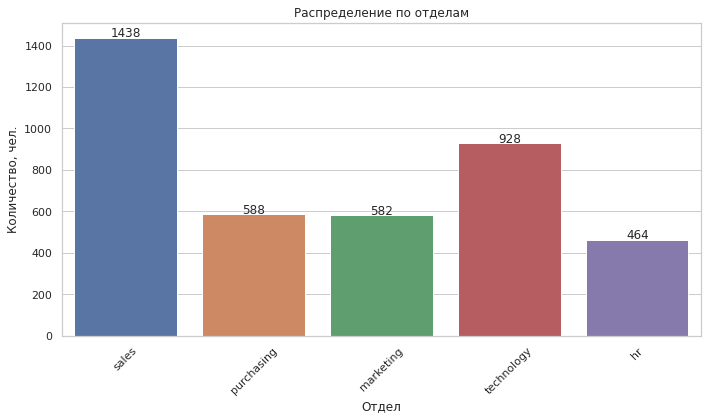

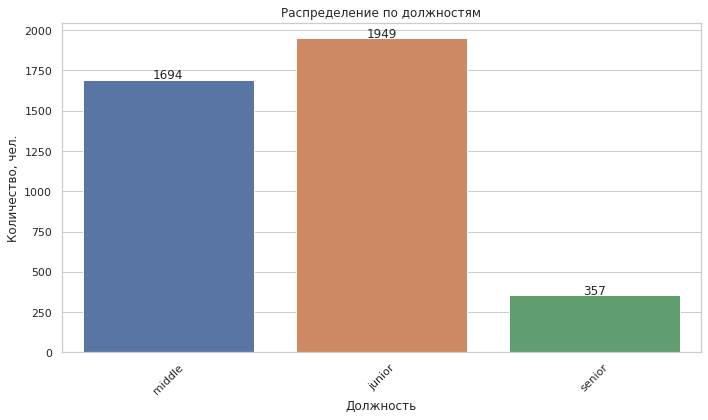

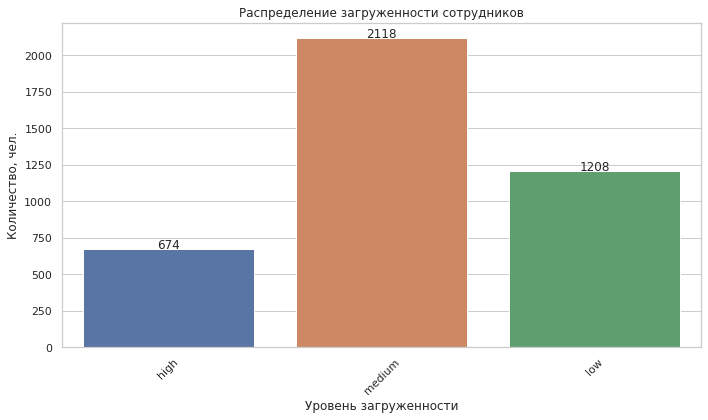

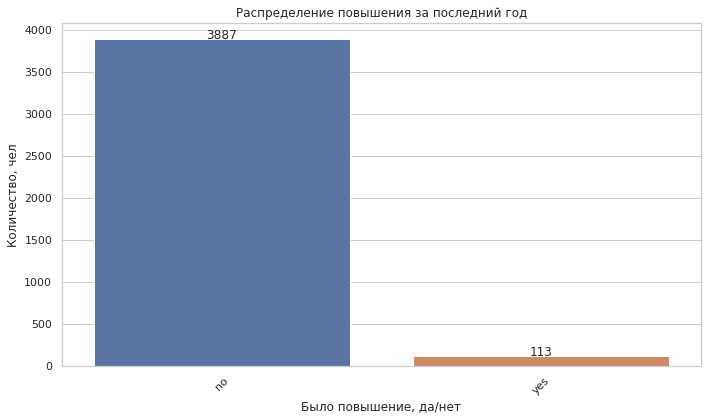

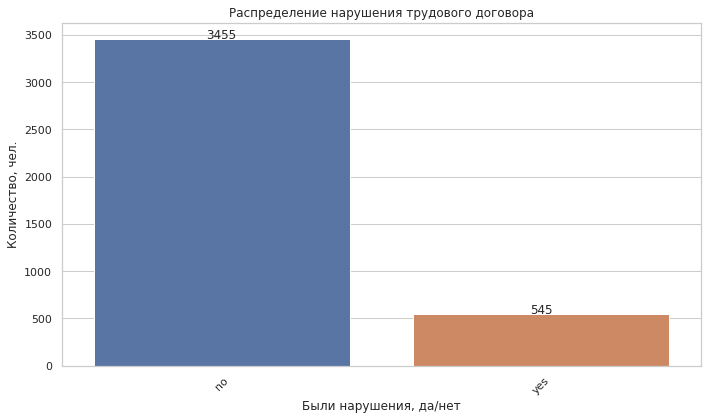

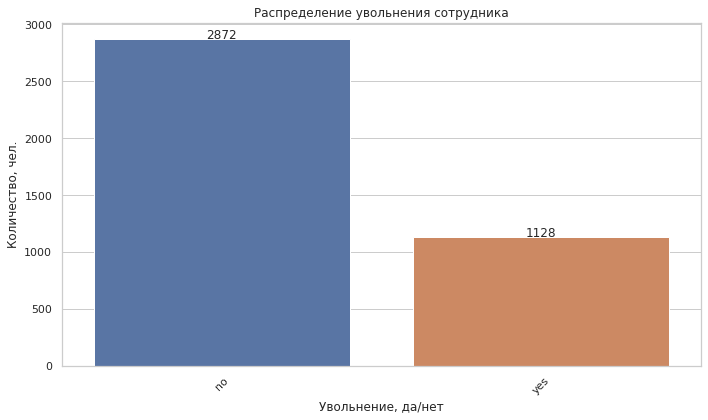

In [169]:
# Категориальные признаки
cat_cols = [
    'employment_years', 
    'supervisor_evaluation', 
    'dept', 
    'level', 
    'workload', 
    'last_year_promo', 
    'last_year_violations',
    'quit'
]

# Словарь с подписями для графиков
labels_dict = {
    'employment_years': ["Распределение длительности работы в компании, г.", "Год", "Количество, чел."], 
    'supervisor_evaluation': ["Распределение оценки качества работы сотрудника", "Оценка", "Количество, чел."],
    'dept': ["Распределение по отделам", "Отдел", "Количество, чел."],
    'level': ["Распределение по должностям", "Должность", "Количество, чел."],
    'workload': ["Распределение загруженности сотрудников", "Уровень загруженности", "Количество, чел."],
    'last_year_promo': ["Распределение повышения за последний год", "Было повышение, да/нет", "Количество, чел"],
    'last_year_violations': ["Распределение нарушения трудового договора", "Были нарушения, да/нет", "Количество, чел."],
    'quit': ["Распределение увольнения сотрудника", "Увольнение, да/нет", "Количество, чел."]
}

# Построение графиков
for col in cat_cols:
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=train_quit, x=col)
    
    # Получаем подписи из словаря (если нет — используем значения по умолчанию)
    title, xlabel, ylabel = labels_dict.get(col, [f'"{col}"', col, 'Частота'])

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)

    # Числовые подписи над столбцами
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x() + p.get_width() / 2,
            y=height + 3.5,
            s=int(height),
            ha='center'
        )

    plt.tight_layout()
    plt.show()

Проведем корреляционный анализ признаков в количественной шкале в таблице train_quit для моделирования. Сделаем выводы о мультиколлинеарности и при необходимости устраним её.

   <br />
    <font color='4682B4'>Нормально распределен только признак зарплаты. Оценим корреляция методом Спирмана V1</font>
</div>

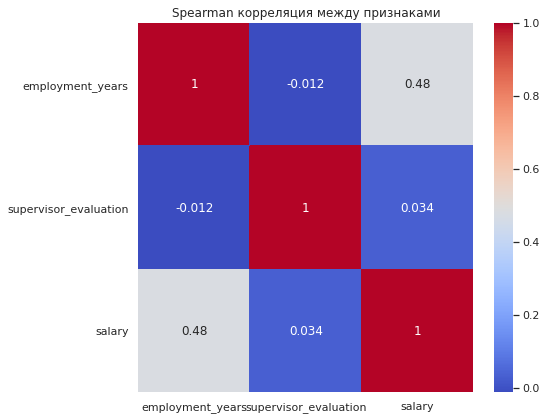

In [171]:
# 1. Корреляция между признаками (коэффициент Спирмена)
num_cols = [
    'employment_years', 
    'supervisor_evaluation', 
    'salary'
]
spearman_corr = train_quit[num_cols].corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm')
plt.title('Spearman корреляция между признаками')
plt.tight_layout()
plt.show()

   <br />
    <font color='4682B4'>В матрице корреляции, максимальное значение 0.48 (умеренная) между employment_years и salary, остальные значения минимальны. Мультиколлинеарности нет..</font>
</div>

   <br />
    <font color='4682B4'>Хитмап для каждого класса V1</font>
</div>

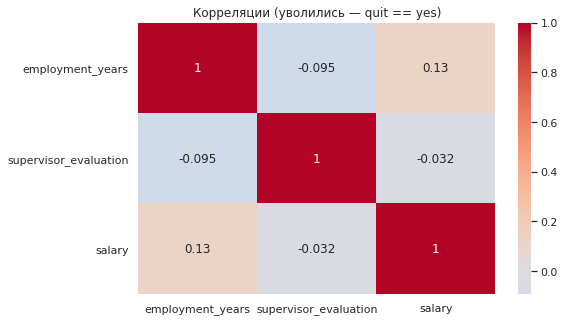

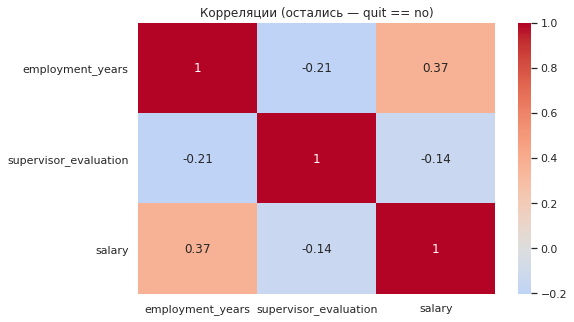

In [172]:
# Разделим на два подмножества
df_yes = train_quit[train_quit['quit'] == 'yes']
df_no = train_quit[train_quit['quit'] == 'no']

# Уберём нечисловые столбцы
num_cols = ['employment_years', 'supervisor_evaluation', 'salary']

# Построим тепловую карту для уволившихся
plt.figure(figsize=(8, 5))
sns.heatmap(df_yes[num_cols].corr(method='spearman'), annot=True, cmap='coolwarm', center=0)
plt.title("Корреляции (уволились — quit == yes)")
plt.show()

# Построим тепловую карту для оставшихся
plt.figure(figsize=(8, 5))
sns.heatmap(df_no[num_cols].corr(method='spearman'), annot=True, cmap='coolwarm', center=0)
plt.title("Корреляции (остались — quit == no)")
plt.show()

В хитмапе "уволились", максимольное значение 0.13 между "employment_yers" и "salary" 0.13, остальные значения минимальны.<br>
В хитмапе "не уволились", максимольное значение 0.37 между "employment_yers" и "salary", далее 0.21 между "employment_yers" и "supervisor_evaluation" и 0.14 между "salary" и "supervisor_evaluation".
</div>

In [173]:
# Входные признаки тестовой выборки
test_features_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [174]:
test_features_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [175]:
test_features_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


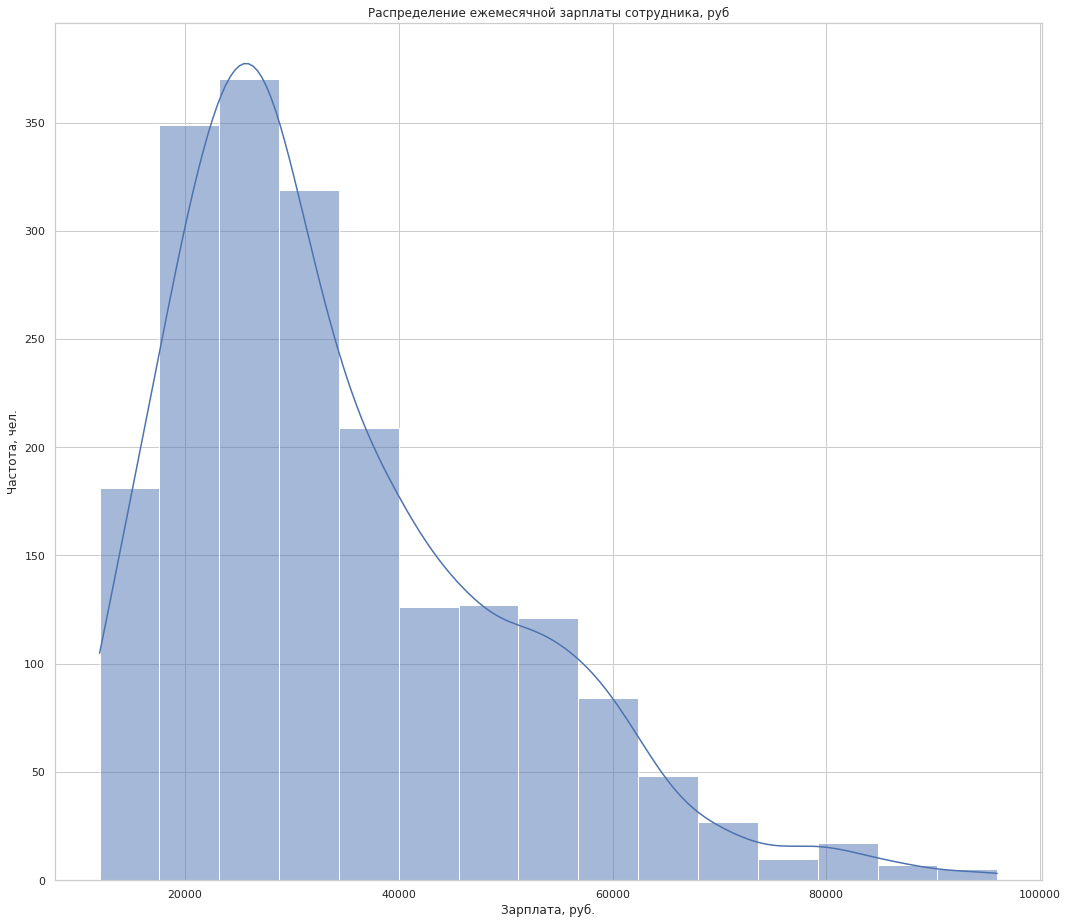

In [176]:
# построим график для количественного признака
num_cols = ['salary']

# Гистограмма с распределением
plt.figure(figsize=(15, 13))
sns.histplot(x='salary', data=test_features_quit, kde=True, bins=15)
plt.title('Распределение ежемесячной зарплаты сотрудника, руб')
plt.xlabel('Зарплата, руб.')  
plt.ylabel('Частота, чел.')  
plt.tight_layout()
plt.show()

   <br />
    <font color='4682B4'>Построим графики с обновленными признаками. V1</font>
</div>

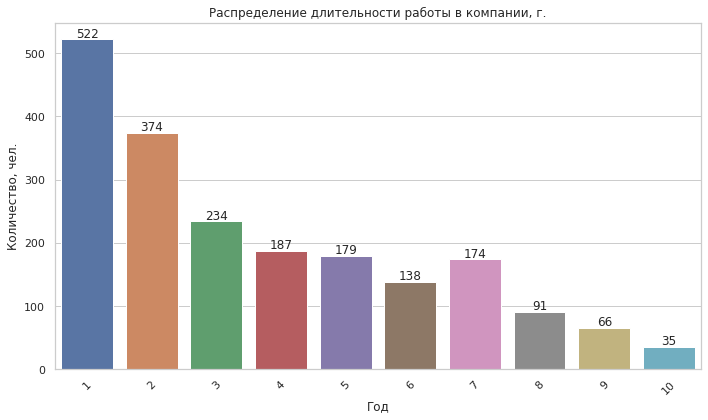

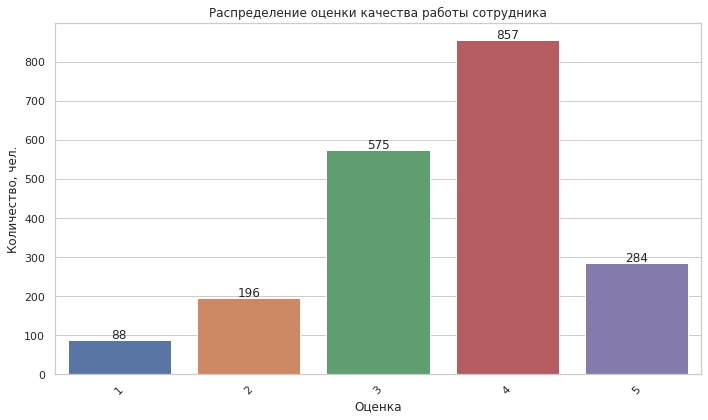

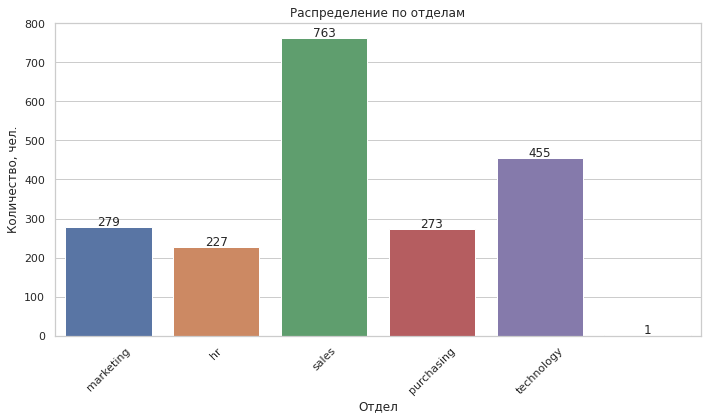

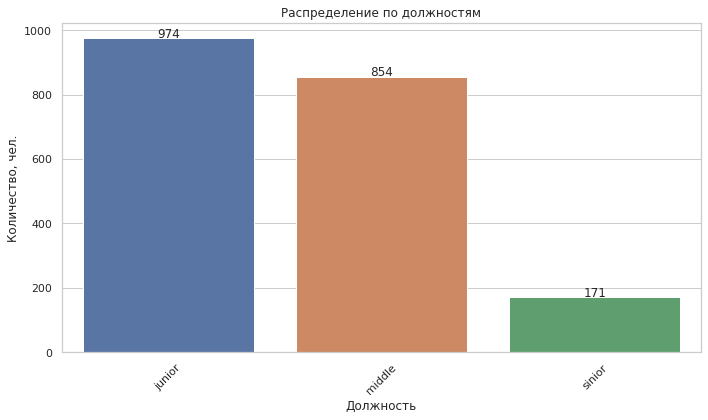

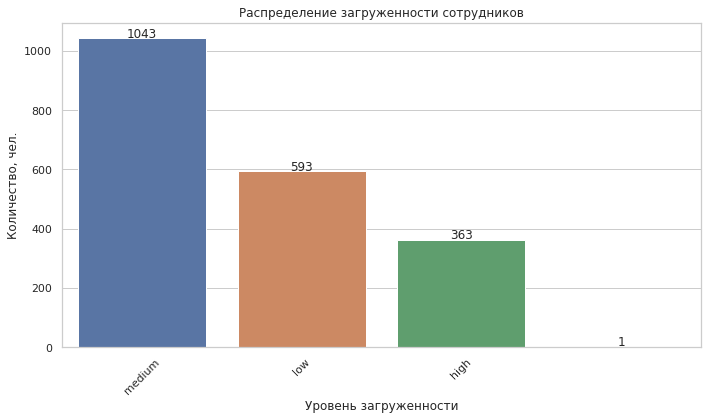

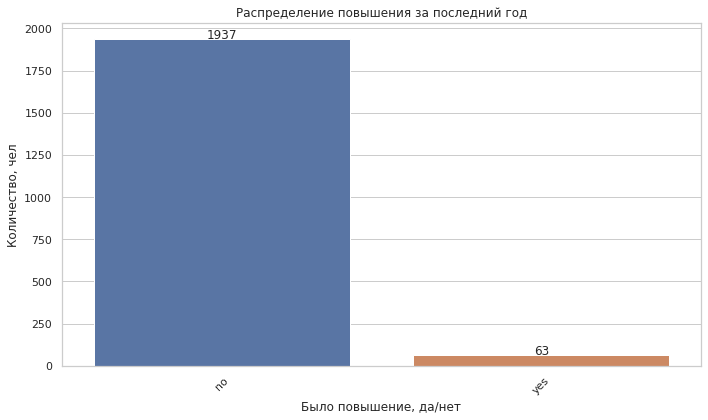

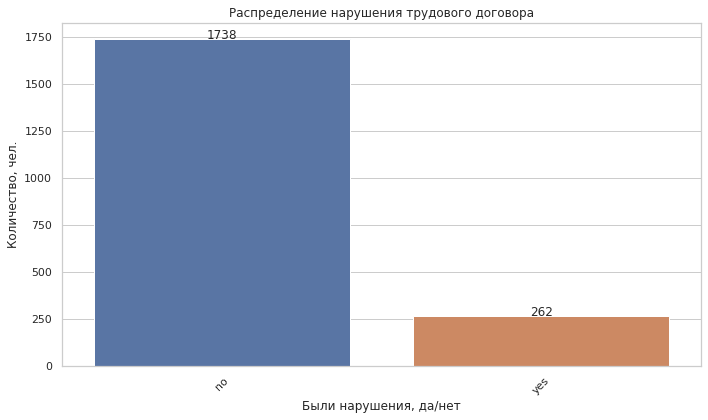

In [178]:
# Категориальные признаки
cat_cols = [
    'employment_years', 
    'supervisor_evaluation', 
    'dept', 
    'level', 
    'workload', 
    'last_year_promo', 
    'last_year_violations'
]

# Словарь с подписями для графиков
labels_dict = {
    'employment_years': ["Распределение длительности работы в компании, г.", "Год", "Количество, чел."], 
    'supervisor_evaluation': ["Распределение оценки качества работы сотрудника", "Оценка", "Количество, чел."],
    'dept': ["Распределение по отделам", "Отдел", "Количество, чел."],
    'level': ["Распределение по должностям", "Должность", "Количество, чел."],
    'workload': ["Распределение загруженности сотрудников", "Уровень загруженности", "Количество, чел."],
    'last_year_promo': ["Распределение повышения за последний год", "Было повышение, да/нет", "Количество, чел"],
    'last_year_violations': ["Распределение нарушения трудового договора", "Были нарушения, да/нет", "Количество, чел."]
}

# Построение графиков
for col in cat_cols:
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=test_features_quit, x=col)
    
    # Получаем подписи из словаря (если нет — используем значения по умолчанию)
    title, xlabel, ylabel = labels_dict.get(col, [f'"{col}"', col, 'Частота'])

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)

    # Числовые подписи над столбцами
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x() + p.get_width() / 2,
            y=height + 3.5,
            s=int(height),
            ha='center'
        )

    plt.tight_layout()
    plt.show()

In [179]:
# Целевой признак тестовой выборки
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [180]:
# Целевой признак тестовой выборки
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [181]:
# числовой
test_target_quit.describe()

,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000


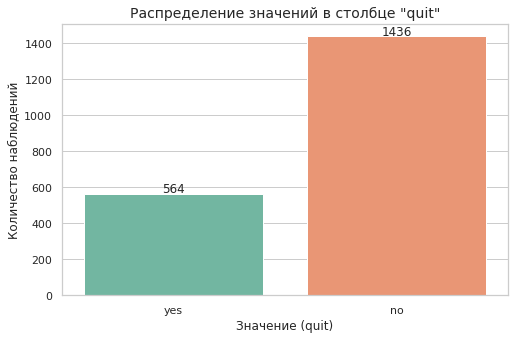

In [182]:
# категоральный
# Настройка стиля графиков
sns.set(style="whitegrid")

# Создаем фигуру
plt.figure(figsize=(8, 5))

# Строим гистограмму
ax = sns.countplot(data=test_target_quit, x='quit', palette='Set2')

# Добавляем подписи
plt.title('Распределение значений в столбце "quit"', fontsize=14)
plt.xlabel('Значение (quit)', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)

# Добавляем аннотации с количеством
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.show()

Изучили и визуализировали данные в таблицах. Данные в норме, аномалий нет.

Составим портрет «уволившегося сотрудника». Узнаем, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.<br>
Проанализируем распределения признаков тренировочной выборки в зависимости от целевого признака (quit — уволился/не уволился).<br>

In [183]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


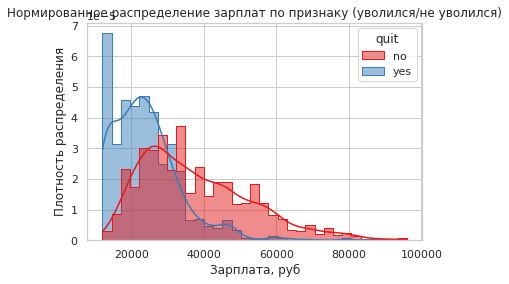

In [184]:
# Количественный признак для визуализации
# Для salary с разбивкой по признаку (уволился/не уволился)
sns.histplot(
    data=train_quit,
    x='salary',
    hue='quit',                   # признак
    kde=True,                     # Добавляет ядерную оценку плотности
    palette='Set1',               # Цветовая схема
    element='step',               # Стиль отображения ("step", "bar", "poly")
    stat='density',               # Нормировка на плотность
    common_norm=False,            # Нормировка внутри каждой группы отдельно
    alpha=0.5                     # Прозрачность для лучшей визуализации
)
plt.title('Нормированное распределение зарплат по признаку (уволился/не уволился)')
plt.xlabel('Зарплата, руб')
plt.ylabel('Плотность распределения')
plt.show()

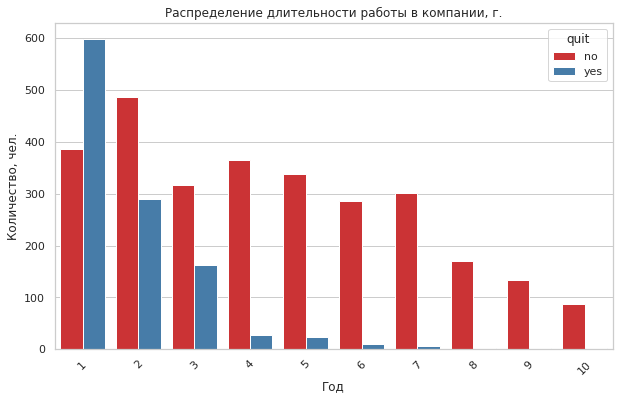

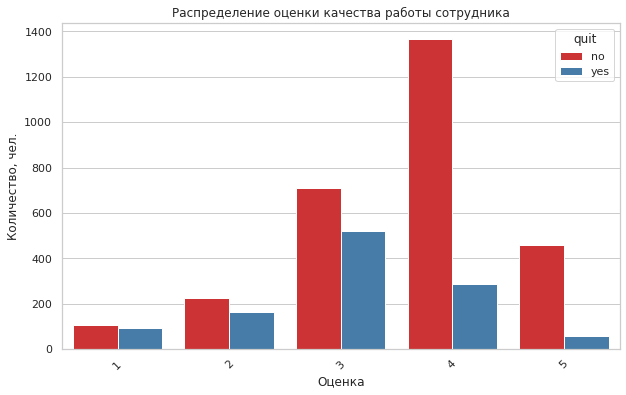

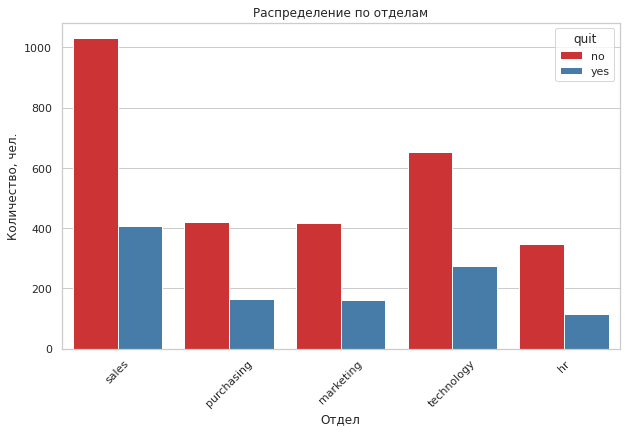

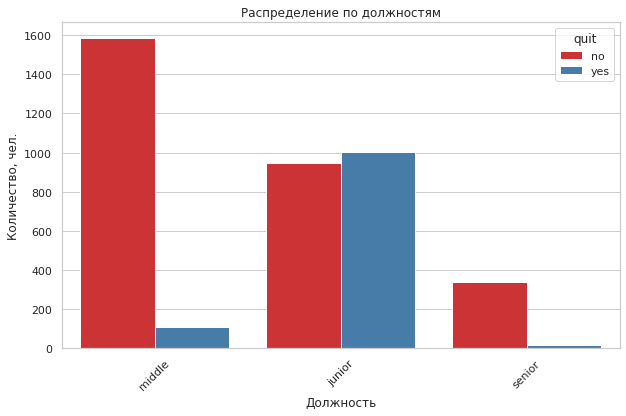

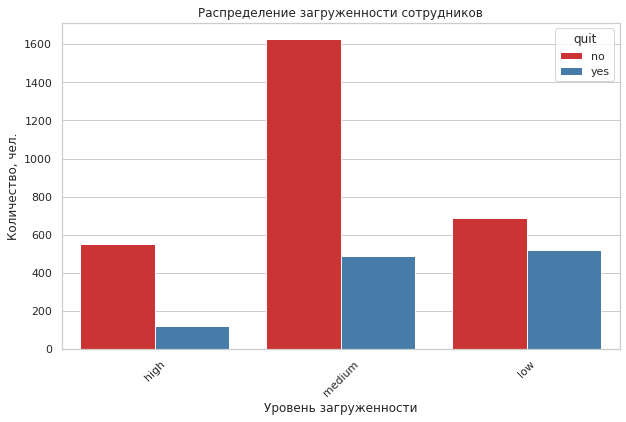

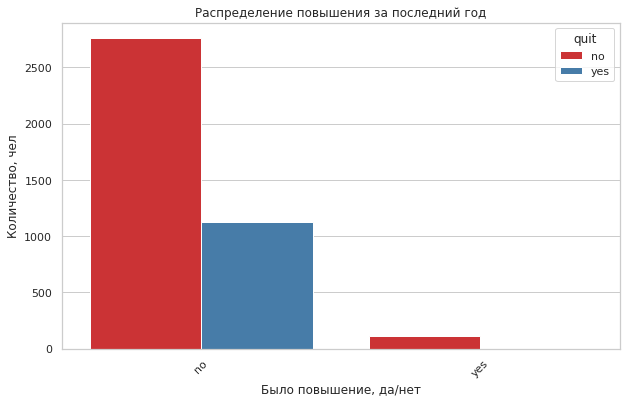

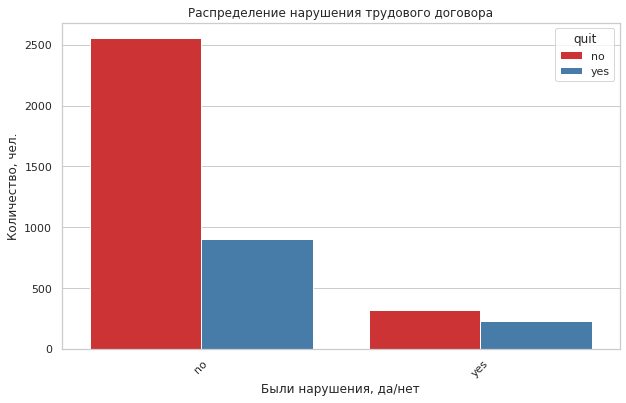

In [186]:
# Категориальные признаки
cat_cols = [
    'employment_years', 
    'supervisor_evaluation', 
    'dept', 
    'level', 
    'workload', 
    'last_year_promo', 
    'last_year_violations'
]

# Словарь с подписями для графиков
labels_dict = {
    'employment_years': ["Распределение длительности работы в компании, г.", "Год", "Количество, чел."], 
    'supervisor_evaluation': ["Распределение оценки качества работы сотрудника", "Оценка", "Количество, чел."],
    'dept': ["Распределение по отделам", "Отдел", "Количество, чел."],
    'level': ["Распределение по должностям", "Должность", "Количество, чел."],
    'workload': ["Распределение загруженности сотрудников", "Уровень загруженности", "Количество, чел."],
    'last_year_promo': ["Распределение повышения за последний год", "Было повышение, да/нет", "Количество, чел"],
    'last_year_violations': ["Распределение нарушения трудового договора", "Были нарушения, да/нет", "Количество, чел."]
}

# Построение графиков
for col in cat_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(
        data=train_quit,
        x=col,
        hue='quit',
        palette='Set1'
    )
    
    # Получаем подписи из словаря (если нет — используем значения по умолчанию)
    title, xlabel, ylabel = labels_dict.get(col, [f'"{col}"', col, 'Частота'])

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.show()

Средняя зарплата:
Ушедшие сотрудники (yes): 23,885.11
Оставшиеся сотрудники (no): 37,702.23
Разница: -13,817.12


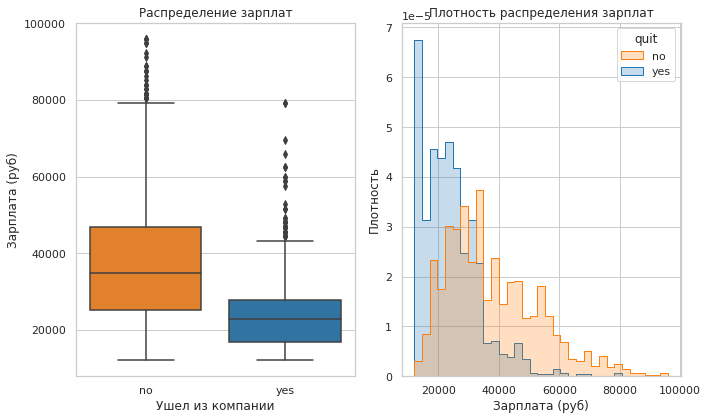

In [187]:
# Настройка стиля
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# 1. Сравнение средних зарплат
mean_salaries = train_quit.groupby('quit')['salary'].mean()
print("Средняя зарплата:")
print(f"Ушедшие сотрудники (yes): {mean_salaries['yes']:,.2f}")
print(f"Оставшиеся сотрудники (no): {mean_salaries['no']:,.2f}")
print(f"Разница: {mean_salaries['yes'] - mean_salaries['no']:,.2f}")

# 2. Boxplot для распределения зарплат
plt.subplot(1, 2, 1)
sns.boxplot(data=train_quit, x='quit', y='salary', palette=['#ff7f0e', '#1f77b4'])
plt.title('Распределение зарплат')
plt.xlabel('Ушел из компании')
plt.ylabel('Зарплата (руб)')

# 3. Гистограммы с наложением
plt.subplot(1, 2, 2)
sns.histplot(data=train_quit, x='salary', hue='quit', 
             element='step', stat='density', 
             common_norm=False, palette=['#ff7f0e', '#1f77b4'])
plt.title('Плотность распределения зарплат')
plt.xlabel('Зарплата (руб)')
plt.ylabel('Плотность')

plt.tight_layout()
plt.show()


Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируем и сравним распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используем данные с обоими целевыми признаками тестовой выборки.

id                       0
job_satisfaction_rate    0
quit                     0
dtype: int64


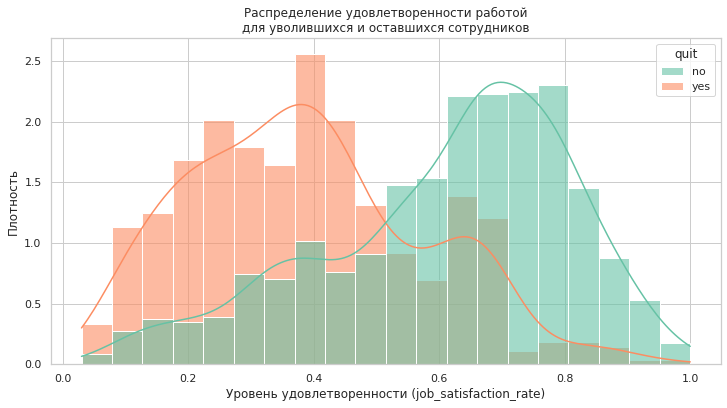

In [188]:
# Объединяем два целевых датафрейма по 'id'
targets = test_target_job_satis.merge(test_target_quit, on='id')

# Проверяем пропуски
print(targets.isna().sum())

plt.figure(figsize=(12, 6))

# Гистограммы с прозрачностью (alpha) и нормировкой
sns.histplot(data=targets, x='job_satisfaction_rate', hue='quit', kde=True, stat='density', common_norm=False,
             palette='Set2', bins=20, alpha=0.6)

plt.title('Распределение удовлетворенности работой\nдля уволившихся и оставшихся сотрудников')
plt.xlabel('Уровень удовлетворенности (job_satisfaction_rate)')
plt.ylabel('Плотность')
plt.grid(True)
plt.show()

</font><font color='Blue'><b>Вывод по исследовательскому анализу</b></font><br>
Провели дальнейший анализ и визуализации для таблиц. Данные в норме, аномалий нет.<br>
В матрице корреляции, максимальное значение 0.47 (умеренная) между employment_years и salary, остальные значения минимальны. Мультиколлинеарности нет.<br>
Балланс классов: "no" - 1436, "yes" - 564. То есть значений "no" больше чем "yes" примерно 3 раза.
Учтем это в аналитике графиков.<br>

Количественные признаки: <br>

Признак "employment_years" (длительность работы в компании, в годах). До 3 лет включительно видна 
тенденция снижения группы "yes" (уволившихся). Далее по годам она также снижается примерно до 7 лет,
дальше это уже редкость.<br>
Признак "supervisor_evaluation" (оценка качества работы сотрудника, которую дал руководитель). Оценку
1 получают обе группы практически одинаково. В оценке 2 ситация похожа, но значения группы "no" немного чаще встречаются. В оценке 3 группа "no" всречается еще чаще, чем группа "yes". В оценке 4 группа "no" встречается чаще примерно в 5 раз. В оценке 5 картина схожа с оценкой 4.<br>
Признак "salary" (ежемесячная зарплата сотрудника). Здесь примерно до 15 000, преобладает группа "yes" и после примерно 25 000 эта группа резко снижается до 40 000 и после 50 000 она встречается крайне редко. Группа "no" резко растет до 30 000, далее постепенно снижается да максимальной зарплаты<br>

Категоральные признаки:<br>

Признак "dept" (отдел, в котором работает сотрудник). Группы "no" и "yes" здесь распределены следующим образом: группа "no" по всем отделам больше группы "yes" примерно в больше чем два раза.<br> 
Признак "level" (уровень занимаемой должности). Здесь в значении "junior" группы "no" и "yes" практически одинаковы. В значениях "middle" и "senior" значительно преобладает группа "no", группа "yes" встречается крайне редко в "middle" и чрезвычайно редко в "senior".<br>
"workload" (уровень загруженности сотрудника). Здесь в значении "low" группы встречаюся часто, немного чаще встречается группа "no". в значении "medium" группа "no" встречается около 1600 раз, а группа "yes" около 500 раз. В значении "high" также преобладает группа "no" (около 550 раз), группа "yes" около 100 раз.<br>
Признак "last_year_promo" (было ли повышение за последний год) имеет два значения no и yes 
(было повышение). В основном данные сосредоточенны в значении no, и там преобладает группа 
"no" больше чем в лва раза. В данных, которые содержат значение yes (было повышение), группа "yes" не
встречается, группа "no" встречается, но релко, около 100 раз.<br>
Признак "last_year_violations" (нарушал ли сотрудник трудовой договор за последний год) имеет два 
значения no и yes соответственно. Основная часть данных находится в значении no (не нарушал) и в нем
значение группы "no" около 2500, а группы "yes" около 800. В данных, которые содержат значение yes 
(было нарушение), группы примерно одинаковы, преобладает группа "no"<br>

Средняя зарплата:<br>
Ушедшие сотрудники (yes): 23,885.11<br>
Оставшиеся сотрудники (no): 37,702.23<br>

Распределение признака job_satisfaction_rate для ушедших и оставшихся сотрудников. <br>
У группы "yes" (уволившиеся) основная часть данных сосредоточенна до значения 0.5. Причем пик 
приходится около 0.4, далее снижается до 0.7 и имеет незначительные случаи от 0.7 до 1.
Группа "no" плавно растет до 0.45 далее сильно растет до пика примерно в 0.7 и плавно снижается до 1.

Портрет удовлетворённого сотрудника (который остаётся в компании):<br>
Имеют стаж более 3 лет, чаще — от 4 до 7 лет. Вероятность увольнения резко снижается после 3 лет работы. Долгосрочная работа повышает удовлетворённость и лояльность.<br>
Получают высокую оценку от руководителя. Особенно стабильны сотрудники с оценкой 4–5 от супервайзера.
Эти оценки наиболее чётко коррелируют с оставшимися сотрудниками.<br>
Имеют зарплату выше 30,000. Средняя ЗП оставшихся сотрудников: 37,702, ушедших — 23,885. Вероятность ухода резко снижается после 25,000. <br>
Во всех департаментах преобладают оставшиеся, особенно в: IT, маркетинге, продажах.<br>
Занимают позиции "middle" и "senior". Сотрудники на уровне junior увольняются чаще. "Senior" почти не уходит — высокая вовлечённость.<br>
Имеют среднюю или высокую загрузку. При этом даже при "high" нагрузке удовлетворённые остаются.<br>
Часто получают повышение. Почти никто не уходит, если было повышение в прошлом году. Ушедшие почти все не получали повышения.<br>
Не нарушают трудовой договор. Среди тех, кто нарушал, риск увольнения выше. Основная масса оставшихся — дисциплинированные.<br>
Имеют уровень удовлетворённости работой выше 0.6. У группы "no" (остались) пик удовлетворённости ≈ 0.7. У "yes" (ушли) — большинство значений ниже 0.5. Таким образом, job_satisfaction_rate — фактор удержания.<br>

Вывод:<br>
Удовлетворённый сотрудник — это тот, кто:<br>
работает более 3 лет<br>
получает хорошую оценку и зарплату<br>
имеет карьерный рост (middle/senior, повышение)<br>
работает стабильно и без нарушений<br>
его работа ценится (оценка, зарплата, удовлетворённость)<br>

Предложение для бизнеса.<br>
Использовать этот портрет в стратегии удержания персонала:<br>
Сфокусироваться на удержании junior с хорошим потенциалом<br>
Предоставлять своевременные повышения и оценки<br>
Прогнозировать увольнение и действовать на опережение<br>
Построить дешборд с рисками увольнения и рекомендациями HR<br>

скорректированны данные корреляции:<br>
V1 В матрице корреляции, максимальное значение 0.48 (умеренная) между employment_years и salary, остальные значения минимальны. Мультиколлинеарности нет.<br>
В хитмапе "уволились", максимольное значение 0.13 между "employment_yers" и "salary" 0.13, остальные значения минимальны.<br>
В хитмапе "не уволились", максимольное значение 0.37 между "employment_yers" и "salary", далее 0.21 между "employment_yers" и "supervisor_evaluation" и 0.14 между "salary" и "supervisor_evaluation".</font>
</div>

### Задача 2. Шаг 4. Добавление нового входного признака 
Добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

Для тренировочной выборки:<br>
Берём истинные значения удовлетворённости (job_satisfaction_rate) из датасета train_job_satis и добавляем их к train_quit, чтобы использовать этот признак как входной при обучении модели по задаче увольнения. Так как в тренировочной выборке у нас есть истинные значения, и они точнее, чем предсказания.<br>
Для тестовой выборки:<br>
Берем предсказанные значения на лучшей модели.<br>

### Задача 2. Шаг 5. Подготовка данных

### Задача 2. Шаг 6. Обучение модели

In [192]:
# 1. Объединение тренировочной выборки с job_satisfaction
train_quit_satis = train_quit.merge(
    train_job_satis[['id', 'job_satisfaction_rate']],
    on='id',
    how='left'
)
train_quit_satis.rename(columns={'job_satisfaction_rate': 'predicted_job_satisfaction'}, inplace=True)

# 2. Предсказание job_satisfaction для тестовой выборки
X_test_for_pred = test_features_quit.drop(columns=['id'], errors='ignore')
test_features_quit['predicted_job_satisfaction'] = best_model.predict(X_test_for_pred)

# 3. Объединение с таргетом
test_quit_merged = test_features_quit.merge(
    test_target_quit[['id', 'quit']],
    on='id',
    how='inner'
)

# 4. Подготовка признаков и таргета
X_cls = train_quit_satis.drop(columns=['id', 'quit'], errors='ignore')
X_cls_test = test_quit_merged.drop(columns=['id', 'quit'], errors='ignore')

# 5. Кодирование целевого признака
le = LabelEncoder()
y_cls = le.fit_transform(train_quit_satis['quit'])
y_cls_test = le.transform(test_quit_merged['quit'])

# 6. Признаки
num_features_cls = ['employment_years', 'supervisor_evaluation', 'salary', 'predicted_job_satisfaction']
cat_ordinal_features_cls = ['level', 'last_year_promo', 'last_year_violations']
cat_nominal_features_cls = ['dept', 'workload']

# 7. Препроцессинг
num_transformer_cls = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_ordinal_transformer_cls = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[
        ['junior', 'middle', 'senior'],
        ['no', 'yes'],
        ['no', 'yes']
    ], handle_unknown='use_encoded_value', unknown_value=-1))
])

cat_nominal_transformer_cls = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_cls = ColumnTransformer(transformers=[
    ('num', num_transformer_cls, num_features_cls),
    ('ord', cat_ordinal_transformer_cls, cat_ordinal_features_cls),
    ('nom', cat_nominal_transformer_cls, cat_nominal_features_cls)
])

# 8. Обучение моделей (только кросс-валидация)
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor_cls),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])
logreg_params = {'clf__C': [0.01, 0.1, 1.0, 10.0]}
grid_logreg = GridSearchCV(logreg_pipeline, logreg_params, cv=5, scoring='roc_auc')
grid_logreg.fit(X_cls, y_cls)
logreg_cv_roc = grid_logreg.best_score_

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor_cls),
    ('clf', RandomForestClassifier(random_state=42))
])
rf_params = {'clf__n_estimators': [50, 100], 'clf__max_depth': [5, 10, 15]}
grid_rf = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='roc_auc')
grid_rf.fit(X_cls, y_cls)
rf_cv_roc = grid_rf.best_score_

hgb_pipeline = Pipeline([
    ('preprocessor', preprocessor_cls),
    ('clf', HistGradientBoostingClassifier(random_state=42))
])
hgb_params = {'clf__learning_rate': [0.01, 0.1], 'clf__max_iter': [100, 200]}
grid_hgb = GridSearchCV(hgb_pipeline, hgb_params, cv=5, scoring='roc_auc')
grid_hgb.fit(X_cls, y_cls)
hgb_cv_roc = grid_hgb.best_score_

# 9. Выбор лучшей модели по кросс-валидации
best_model = grid_hgb.best_estimator_
best_model_cls_name = 'HistGradientBoosting'
best_cv_score = hgb_cv_roc

if logreg_cv_roc > best_cv_score:
    best_model = grid_logreg.best_estimator_
    best_model_cls_name = 'Logistic Regression'
    best_cv_score = logreg_cv_roc

if rf_cv_roc > best_cv_score:
    best_model = grid_rf.best_estimator_
    best_model_cls_name = 'Random Forest'
    best_cv_score = rf_cv_roc

# 10. Тестирование только лучшей модели
test_roc_auc = roc_auc_score(y_cls_test, best_model.predict_proba(X_cls_test)[:, 1])

# 11. Вывод
print(f"\n Лучшая модель по кросс-валидации: {best_model_cls_name} (ROC-AUC: {best_cv_score:.3f})")
print(f" ROC-AUC на тестовой выборке: {test_roc_auc:.3f}")

if test_roc_auc >= 0.91:
    print(" Успех: ROC-AUC ≥ 0.91")
else:
    print(" Недостаточно: ROC-AUC < 0.91 — попробуйте изменить признаки или параметры")



 Лучшая модель по кросс-валидации: Random Forest (ROC-AUC: 0.939)
 ROC-AUC на тестовой выборке: 0.932
 Успех: ROC-AUC ≥ 0.91


### Задача 2. Шаг 7. Выводы¶

Вывод по выбору модели
Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥0.91 на тестовой выборке.
Все три модели показали хорошие результаты, но:
Random Forest — лучшая модель с ROC-AUC 0.932.

Почему победил Random Forest:
Он хорошо работает с разнородными признаками, особенно категориальными (которые у нас есть).
Устойчив к выбросам и нелинейным зависимостям.
Объединение predicted_job_satisfaction дало модели дополнительную полезную информацию о поведении сотрудников.

При решении учли правильное формирование тестовой выборки как в первой задаче. Ошибка была в разной индексации порядка "id" в таблицах тестовых выборок с входными и целевым признакам. Объединение этих таблиц по "id" решило проблему.
При решении использвали пайплайн и три модели указанных выше. Для кодирования целевого признака  использовали LabelEncoder</font>
</div>

### Общий вывод

Цель.<br>
Построить модели для:<br>
Прогнозирования уровня удовлетворённости работой (job_satisfaction_rate)<br>
Предсказания увольнения сотрудника (quit)<br>

В этапы работы для двух задач вошли: изучение данных; исследовательский анализ с формированием портрета сотрудника; подготовка данных; обучение моделей; выводы.<br>

Задача 1 — Регрессия удовлетворённости работой<br>
Лучшая модель: HistGradientBoostingRegressor<br>
SMAPE на тесте: 11.60 — отличный результат (лучше порогового значения 15)<br>
Модель эффективно предсказывает удовлетворённость, опираясь на:<br>
Оценку супервайзера<br>
Стаж<br>
ЗП<br>
Должность и департамент<br>
Задача 2 — Классификация увольнения<br>
Лучшая модель: RandomForestClassifier<br>
ROC-AUC на тесте: 0.932 — (выше порога 0.91)<br>
Модель дополнительно использовала предсказанный уровень удовлетворённости из первой задачи, что значительно повысило точность.<br>
Что это даёт бизнесу?<br>
Практическое применение моделей:<br>
Прогнозировать увольнения заранее.<br>
Внедрение модели в HR-аналитику позволяет выявлять сотрудников с высоким риском увольнения за 1–3 месяца до ухода.<br>
Это даёт время на:<br>
Индивидуальные беседы<br>
Повышение/перераспределение нагрузки<br>
Бонусную или образовательную поддержку<br>
Анализировать неудовлетворённость. Модель регрессии помогает определить, почему сотрудник может быть недоволен:<br>
Слишком низкая оценка от руководителя<br>
Малый стаж, но уже высокая нагрузка<br>
Не было повышения в прошлом году и т.д.<br>
HR-отдел может использовать эти паттерны для улучшения внутренних процессов.
Оптимизация затрат:<br>
Увольнение и найм нового сотрудника — это дорого. Предотвращение 1 увольнения ≈ экономия в 2–3 месячных оклада.<br>
Предиктивная модель помогает:<br>
Удерживать ключевых людей<br>
Снижать текучесть<br>
Формировать прогноз затрат на удержание<br>

Возможности развития и внедрения<br>
Внедрение в продакшн:<br>
Модель может использоваться на живых данных (актуальный список сотрудников).<br>
Предсказания можно пересчитывать ежемесячно или ежеквартально.<br>
Для лучшей работы:<br>
Подключить больше данных:<br>
Уровень вовлечённости (опросы, участие в проектах)<br>
История отпусков, переработок<br>
Командная структура и вовлечённость руководителя<br>
Сделать дешборд для HR:<br>
Показать прогнозируемые увольнения + возможные причины<br>
Фильтры: департамент, стаж, уровень, супервайзер и т.д.<br>